# EE702: Computer Vision Assignment 1

## Imports

In [ ]:
import cv2
import math
from tqdm import *
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.morphology import skeletonize
from scipy.ndimage import laplace
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## Initialization of parameters

In [ ]:
# Defining question parameters
grid_size = 64
e1=0.0
e2=0.0
s_hat = [e1,e2,1]

noise_radiance = 0
alpha = 1

## Finding Ground Truth Depths

In [ ]:
#Creation of Spherical Depth Map
z_ground_truth = np.zeros((grid_size,grid_size))
r = 16

# Creating Mesh Grid
[cols,rows] 	 = np.meshgrid(range(grid_size),range(grid_size))

# Calculation of z as a sphere
for i in range(0,grid_size):
	for j in range(0,grid_size):
		z_ground_truth[i][j] = r**2 - math.pow(cols[i][j] - grid_size/2 , 2) - math.pow(rows[i][j] - grid_size/2 , 2);

#Define ROI around the object's 3D rendering
ROI = z_ground_truth > 0
z_ground_truth = np.sqrt(z_ground_truth * ROI)

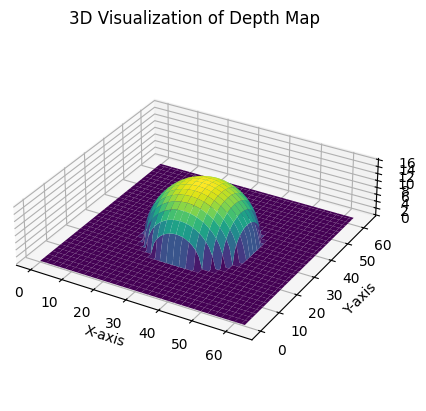

In [ ]:
#Visualization of 3D Depth Map
grid_x, grid_y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, z_ground_truth, cmap=cm.viridis)
ax.set_box_aspect((np.ptp(grid_x), np.ptp(grid_y), np.ptp(z_ground_truth)))
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Depth')
ax.set_title('3D Visualization of Depth Map')
plt.show()


## Calculating ground truth p and q

In [ ]:
p = np.zeros((grid_size,grid_size))
q = np.zeros((grid_size,grid_size))

for i in range(1,grid_size-1):
	for j in range(1,grid_size-1):
		p[i][j] = z_ground_truth[i][j] - z_ground_truth[i-1][j]
		q[i][j] = z_ground_truth[i][j] - z_ground_truth[i][j-1]

p *= ROI
q *= ROI

## Calculating irradiance E(x, y)

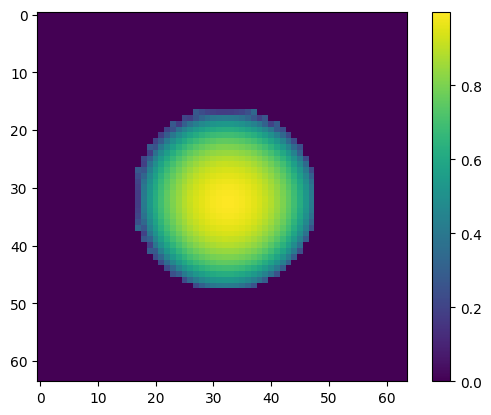

In [ ]:
# Compute E(x,y) = (n.s)^alpha from p,q,s,alpha
E = np.zeros((grid_size,grid_size))
for i in range(0,grid_size):
	for j in range(0,grid_size):
		if(ROI[i][j]):
			E[i][j] = ((-p[i,j]*s_hat[0] + -q[i,j]*s_hat[1] + 1*s_hat[2])/(((s_hat[0]**2+s_hat[1]**2+s_hat[2]**2)**0.5)*((p[i,j]**2 + q[i,j]**2 + 1**2)**0.5)))**alpha

#Ignore negative values
E[E < 0] = 0

E_max = E.max()

noise_std = noise_radiance * E_max
E += np.random.normal(0, noise_std, E.shape)

# Visualize the image irradiance
plt.imshow(E, cmap='viridis')
plt.colorbar()
plt.show()

## Estimating p and q values at boundary using E

In [ ]:
def gac_boundary(E, iterations=200, smoothing=1):
    E_ = (E * 255).astype(np.uint8)
    gimg = inverse_gaussian_gradient(E)

    init_ls = np.zeros_like(E, dtype=np.int8)
    h, w = E.shape
    init_ls[h // 2 - 10 : h // 2 + 10, w // 2 - 10 : w // 2 + 10] = 1  # Small square in center

    ls = morphological_geodesic_active_contour(gimg, iterations, init_ls, smoothing=smoothing)

    laplacian = laplace(ls)
    boundary = np.abs(laplacian) > 0.05
    boundary = skeletonize(boundary).astype(np.float32)

    return boundary


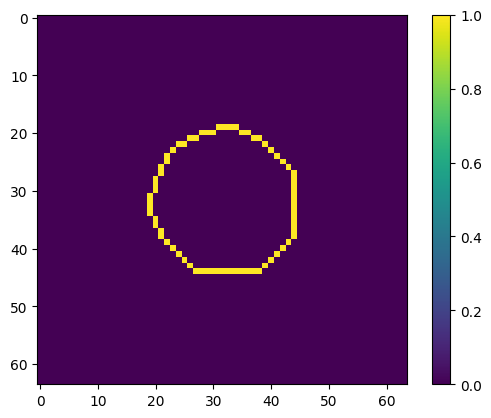

In [ ]:
boundary = gac_boundary(E)
# Visualization
plt.imshow(boundary, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
# Gradients at boundaries
diff_X, diff_Y       = deepcopy(E), deepcopy(E)
diff_X[1:-1, :] = (E[2:, :] - E[:-2, :]) / 2
diff_Y[:, 1:-1] = (E[:, 2:] - E[:, :-2]) / 2

p_hat_boundary = diff_X * boundary
q_hat_boundary = diff_Y * boundary


In [ ]:
p_hat_boundary.min()

-0.08044545784724211

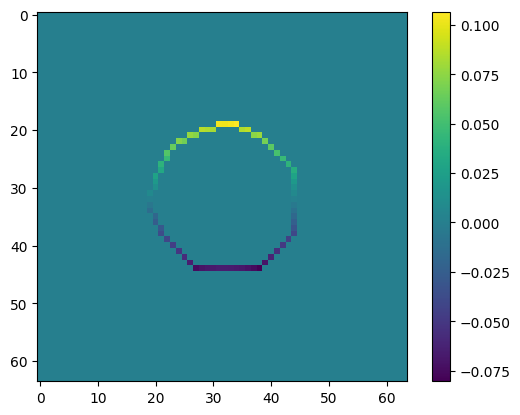

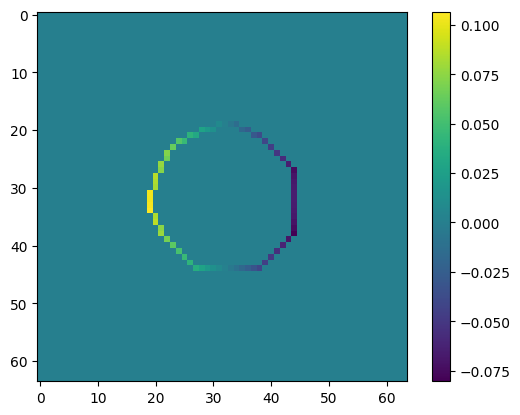

In [ ]:
# Visualize pBoundary
plt.imshow(p_hat_boundary, cmap='viridis')
plt.colorbar()
plt.show()

# Visualize qBoundary
plt.imshow(q_hat_boundary, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
pq_limit = 10000
z_limit = 10000

λ = 100		 # Regularization

In [ ]:
p_new,q_new, p_hat,q_hat = deepcopy(p_hat_boundary), deepcopy(q_hat_boundary), deepcopy(p_hat_boundary), deepcopy(q_hat_boundary)
ROI_E = E > 0

for t in tqdm(range(pq_limit)):
	for i in range(1,grid_size-1):
		for j in range(1,grid_size-1):
			if ROI_E[i][j]:
				mod_s = (s_hat[0]**2 + s_hat[1]**2 + 1)**0.5
				mod_n = (p_hat[i][j]**2 + q_hat[i][j]**2 + 1)**0.5;
				R = (-p_hat[i][j] * s_hat[0] - q_hat[i][j] * s_hat[1] + 1) / ( mod_s *mod_n)
				Rp = (-s_hat[0] - (q_hat[i][j]**2)*s_hat[0] + p_hat[i][j]*q_hat[i][j]*s_hat[1] - p_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
				Rq = (-s_hat[1] - (p_hat[i][j]**2)*s_hat[1] + p_hat[i][j]*q_hat[i][j]*s_hat[0] - q_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
				p_new[i][j] = 0.25*(p_hat[i-1][j] + p_hat[i+1][j] + p_hat[i][j-1] + p_hat[i][j+1]) - 1/λ *(E[i][j] - R)*Rp;
				q_new[i][j] = 0.25*(q_hat[i-1][j] + q_hat[i+1][j] + q_hat[i][j-1] + q_hat[i][j+1]) - 1/λ *(E[i][j] - R)*Rq;
	p_hat = (p_new*ROI_E*(1-boundary.astype(bool))) + p_hat_boundary*boundary*ROI_E
	q_hat = (q_new*ROI_E*(1-boundary.astype(bool))) + q_hat_boundary*boundary*ROI_E


100%|██████████| 10000/10000 [02:08<00:00, 77.61it/s]


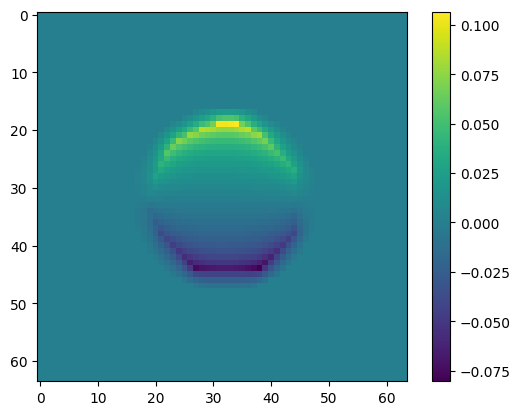

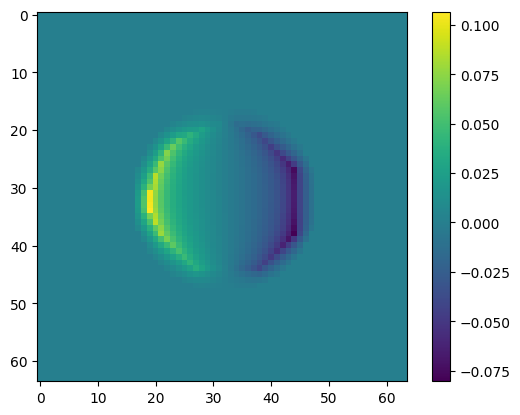

In [ ]:
# Visualize p_hat abd q_hat
plt.imshow(p_hat, cmap='viridis')
plt.colorbar()
plt.show()

plt.imshow(q_hat, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
# Depth Retrieval
Z_p   = np.zeros(p_hat.shape)
Z     = np.zeros(p_hat.shape)
Z_p[grid_size//2][grid_size//2] = 16

p_x,q_y = np.zeros(p_hat.shape),np.zeros(q_hat.shape)

p_x[1:-1, :] = (p_hat[2:, :] - p_hat[:-2, :]) * 0.5
q_y[:, 1:-1] = (q_hat[:, 2:] - q_hat[:, :-2]) * 0.5

for iteration in tqdm(range(0,z_limit)):
	for i in range(1,p_hat.shape[0]-1):
		for j in range(1,p_hat.shape[1]-1):
			if ROI_E[i][j] == 1 :
				Z[i][j] = 0.25*( Z_p[i-1][j] + Z_p[i+1][j] + Z_p[i][j-1] + Z_p[i][j+1]) + abs(p_x[i][j]) + abs(q_y[i][j])
	Z_p = ROI_E*Z;

Z_hat = Z * ROI_E

100%|██████████| 10000/10000 [01:48<00:00, 92.13it/s]


In [ ]:
Z_hat = Z_hat * 16/abs(Z_hat).max()

In [ ]:
Z_hat.max()

2.7512680117713857

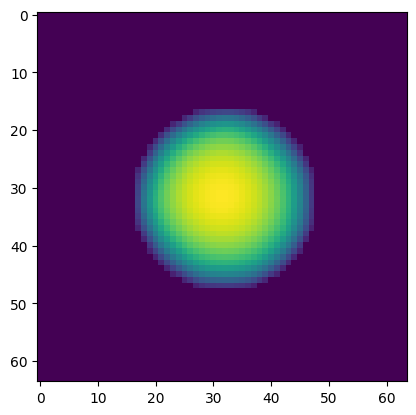

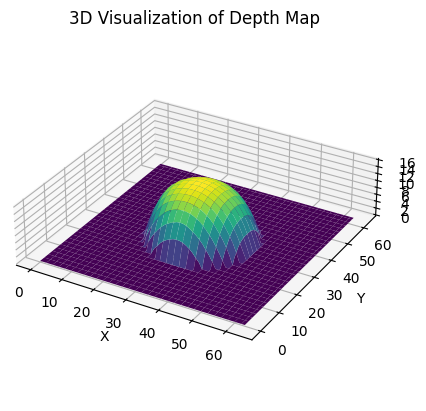

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

filename = f"defaykt"

# 2D visualization
plt.imshow(Z_hat)
plt.savefig('/content/2dmap')

# 3D visualization

X, Y = np.meshgrid(np.arange(0, grid_size), np.arange(0, grid_size))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_hat, cmap=cm.viridis)
ax.set_box_aspect((np.ptp(X), np.ptp(Y), np.ptp(Z_hat)))

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Depth Map')

# Display the plot
plt.show()

Mean Absolute Error (MAE): 0.20092426547357176
Root Mean Squared Error (RMSE): 0.5759438874334322
Maximum Absolute Error: 2.8600290272488165
Relative Root Mean Squared Error (rel_RMSE): 0.2753885966420812


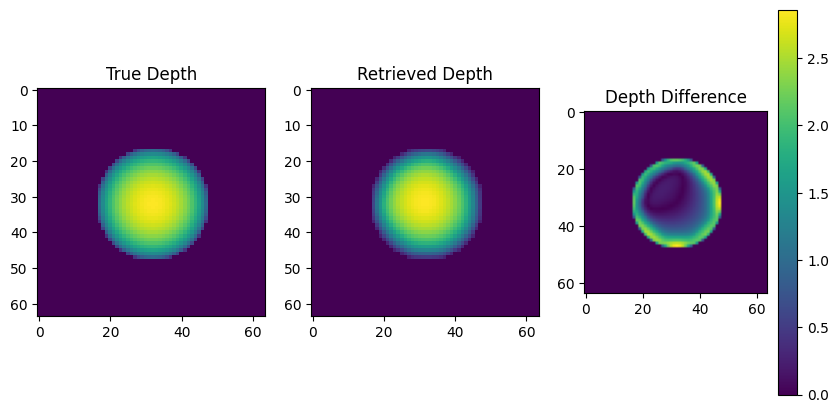

In [ ]:
# Calculate the difference between true depth and retrieved depth
depth_difference = np.abs(z_ground_truth - Z_hat)

# Calculate metrics to compare the depth maps

# 1. Mean Absolute Error (MAE)
mae = np.mean(depth_difference)
print("Mean Absolute Error (MAE):", mae)

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(depth_difference**2))
print("Root Mean Squared Error (RMSE):", rmse)

# 3. Maximum Absolute Error
max_error = np.max(depth_difference)
print("Maximum Absolute Error:", max_error)

# 4. Relative Root Mean Squared Error
rel_rmse = rmse / np.mean(z_ground_truth)
print("Relative Root Mean Squared Error (rel_RMSE):", rel_rmse)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(z_ground_truth, cmap='viridis')
plt.title('True Depth')

plt.subplot(1, 3, 2)
plt.imshow(Z_hat, cmap='viridis')
plt.title('Retrieved Depth')

plt.subplot(1, 3, 3)
plt.imshow(depth_difference, cmap='viridis')
plt.title('Depth Difference')

plt.colorbar()
plt.show()
#for no noise no epsilon

In [ ]:
def SFS(alpha, r, e1, e2, noise_radiance, lamb, grid_size=64, pq_limit=1000, z_limit=1000):
  z_ground_truth = np.zeros((grid_size,grid_size))

  # Creating Mesh Grid
  [cols,rows] 	 = np.meshgrid(range(grid_size),range(grid_size))
  s_hat = [e1,e2,1]

  # Calculation of z as a sphere
  for i in range(0,grid_size):
    for j in range(0,grid_size):
      z_ground_truth[i][j] = r**2 - math.pow(cols[i][j] - grid_size/2 , 2) - math.pow(rows[i][j] - grid_size/2 , 2);

  #Define ROI around the object's 3D rendering
  ROI = z_ground_truth > 0
  z_ground_truth = np.sqrt(z_ground_truth * ROI)

  #Visualization of 3D Depth Map
  grid_x, grid_y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(grid_x, grid_y, z_ground_truth, cmap=cm.viridis)
  ax.set_box_aspect((np.ptp(grid_x), np.ptp(grid_y), np.ptp(z_ground_truth)))
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Depth')
  ax.set_title('3D Visualization of Depth Map')
  plt.show()

  """## Calculating ground truth p and q"""

  p = np.zeros((grid_size,grid_size))
  q = np.zeros((grid_size,grid_size))

  for i in range(1,grid_size-1):
    for j in range(1,grid_size-1):
      p[i][j] = z_ground_truth[i][j] - z_ground_truth[i-1][j]
      q[i][j] = z_ground_truth[i][j] - z_ground_truth[i][j-1]

  p *= ROI
  q *= ROI

  """## Calculating irradiance E(x, y)"""

  # Compute E(x,y) = (n.s)^alpha from p,q,s,alpha
  E = np.zeros((grid_size,grid_size))
  for i in range(0,grid_size):
    for j in range(0,grid_size):
      if(ROI[i][j]):
        E[i][j] = ((-p[i,j]*s_hat[0] + -q[i,j]*s_hat[1] + 1*s_hat[2])/(((s_hat[0]**2+s_hat[1]**2+s_hat[2]**2)**0.5)*((p[i,j]**2 + q[i,j]**2 + 1**2)**0.5)))**alpha

  #Ignore negative values outside the ROI
  E[E < 0] = 0

  E_max = E.max()

  noise_std = noise_radiance * E_max
  E += np.random.normal(0, noise_std, E.shape)

  # Visualize the image irradiance
  plt.imshow(E, cmap='viridis')
  plt.colorbar()
  plt.title("E(x,y)")
  plt.show()

  """## Estimating p and q values at boundary using E"""

  #Compute occluding boundary from E(x,y)
  def gac_boundary(E, iterations=200, smoothing=1):
      E_ = (E * 255).astype(np.uint8)
      gimg = inverse_gaussian_gradient(E)

      init_ls = np.zeros_like(E, dtype=np.int8)
      h, w = E.shape
      init_ls[h // 2 - 10 : h // 2 + 10, w // 2 - 10 : w // 2 + 10] = 1  # Small square in center

      ls = morphological_geodesic_active_contour(gimg, iterations, init_ls, smoothing=smoothing)

      laplacian = laplace(ls)
      boundary = np.abs(laplacian) > 0.05
      boundary = skeletonize(boundary).astype(np.float32)

      return boundary

  boundary = gac_boundary(E)
  # Visualization
  plt.imshow(boundary, cmap='viridis')
  plt.colorbar()
  plt.show()

  # Compute p and q at occluding boundary
  diff_X, diff_Y       = deepcopy(E), deepcopy(E)
  diff_X[1:-1, :] = (E[2:, :] - E[:-2, :]) / 2
  diff_Y[:, 1:-1] = (E[:, 2:] - E[:, :-2]) / 2

  p_hat_boundary = diff_X * boundary
  q_hat_boundary = diff_Y * boundary

  p_hat_boundary.min()

  # Visualize pBoundary
  plt.imshow(p_hat_boundary, cmap='viridis')
  plt.colorbar()
  plt.show()

  # Visualize qBoundary
  plt.imshow(q_hat_boundary, cmap='viridis')
  plt.colorbar()
  plt.show()

  p_new,q_new, p_hat,q_hat = deepcopy(p_hat_boundary), deepcopy(q_hat_boundary), deepcopy(p_hat_boundary), deepcopy(q_hat_boundary)
  ROI_E = E > 0

  #Loop over all pixels for 10k iterations
  for t in tqdm(range(pq_limit)):
    for i in range(1,grid_size-1):
      for j in range(1,grid_size-1):
        if ROI_E[i][j]:
          mod_s = (s_hat[0]**2 + s_hat[1]**2 + 1)**0.5
          mod_n = (p_hat[i][j]**2 + q_hat[i][j]**2 + 1)**0.5;
          R = (-p_hat[i][j] * s_hat[0] - q_hat[i][j] * s_hat[1] + 1) / ( mod_s *mod_n)
          Rp = (-s_hat[0] - (q_hat[i][j]**2)*s_hat[0] + p_hat[i][j]*q_hat[i][j]*s_hat[1] - p_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
          Rq = (-s_hat[1] - (p_hat[i][j]**2)*s_hat[1] + p_hat[i][j]*q_hat[i][j]*s_hat[0] - q_hat[i][j]*s_hat[2])/(mod_s * mod_n**3)
          p_new[i][j] = 0.25*(p_hat[i-1][j] + p_hat[i+1][j] + p_hat[i][j-1] + p_hat[i][j+1]) - 1/lamb *(E[i][j] - R)*Rp;
          q_new[i][j] = 0.25*(q_hat[i-1][j] + q_hat[i+1][j] + q_hat[i][j-1] + q_hat[i][j+1]) - 1/lamb *(E[i][j] - R)*Rq;
    p_hat = (p_new*ROI_E*(1-boundary.astype(bool))) + p_hat_boundary*boundary*ROI_E
    q_hat = (q_new*ROI_E*(1-boundary.astype(bool))) + q_hat_boundary*boundary*ROI_E

  # Visualize p_hat abd q_hat
  plt.imshow(p_hat, cmap='viridis')
  plt.colorbar()
  plt.show()

  plt.imshow(q_hat, cmap='viridis')
  plt.colorbar()
  plt.show()

  # Depth Retrieval
  Z_p   = np.zeros(p_hat.shape)
  Z     = np.zeros(p_hat.shape)

  p_x,q_y = np.zeros(p_hat.shape),np.zeros(q_hat.shape)

  p_x[1:-1, :] = (p_hat[2:, :] - p_hat[:-2, :]) * 0.5
  q_y[:, 1:-1] = (q_hat[:, 2:] - q_hat[:, :-2]) * 0.5

  #Loop over all p and q
  for iteration in tqdm(range(0,z_limit)):
    for i in range(1,p_hat.shape[0]-1):
      for j in range(1,p_hat.shape[1]-1):
        if ROI_E[i][j] == 1 :
          Z[i][j] = 0.25*( Z_p[i-1][j] + Z_p[i+1][j] + Z_p[i][j-1] + Z_p[i][j+1]) + abs(p_x[i][j]) + abs(q_y[i][j])
    Z_p = ROI_E*Z;

  Z_hat = Z * ROI_E

  Z_hat = Z_hat * 16/abs(Z_hat).max()

  Z_hat.max()

  filename = f"defaykt"

  # 2D visualization
  plt.imshow(Z_hat)
  plt.savefig('/content/2dmap')

  # 3D visualization

  X, Y = np.meshgrid(np.arange(0, grid_size), np.arange(0, grid_size))
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X, Y, Z_hat, cmap=cm.viridis)
  ax.set_box_aspect((np.ptp(X), np.ptp(Y), np.ptp(Z_hat)))
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('3D Visualization of Depth Map')
  plt.show()

  # Calculate the difference between true depth and retrieved depth
  depth_difference = np.abs(z_ground_truth - (-Z_hat)*16/Z_hat.max())

  # Calculate metrics to compare the depth maps

  # 1. Mean Absolute Error (MAE)
  mae = np.mean(depth_difference)
  print("Mean Absolute Error (MAE):", mae)

  # 2. Root Mean Squared Error (RMSE)
  rmse = np.sqrt(np.mean(depth_difference**2))
  print("Root Mean Squared Error (RMSE):", rmse)

  # 3. Maximum Absolute Error
  max_error = np.max(depth_difference)
  print("Maximum Absolute Error:", max_error)

  # 4. Relative Root Mean Squared Error
  rel_rmse = rmse / np.mean(z_ground_truth)
  print("Relative Root Mean Squared Error (rel_RMSE):", rel_rmse)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(z_ground_truth, cmap='viridis')
  plt.title('True Depth')

  plt.subplot(1, 3, 2)
  plt.imshow(Z_hat, cmap='viridis')
  plt.title('Retrieved Depth')

  plt.subplot(1, 3, 3)
  plt.imshow(depth_difference, cmap='viridis')
  plt.title('Depth Difference')

  plt.colorbar()
  plt.show()
  #for no noise no epsilon
  return p_hat, q_hat, Z_hat

A part

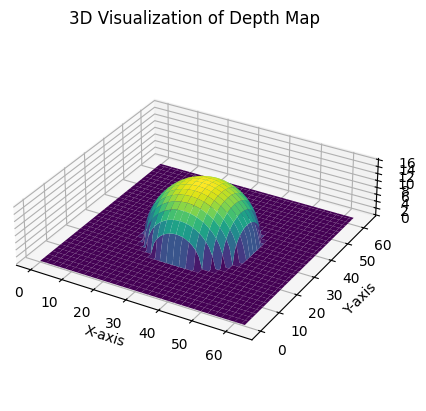

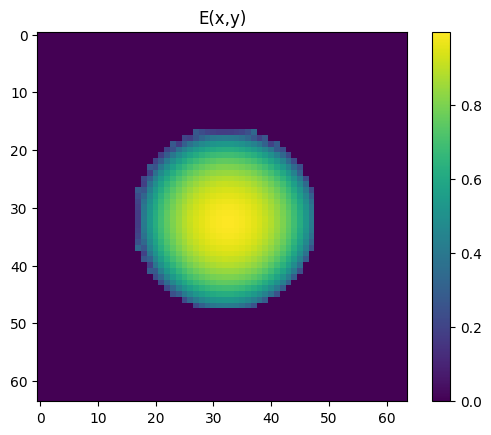

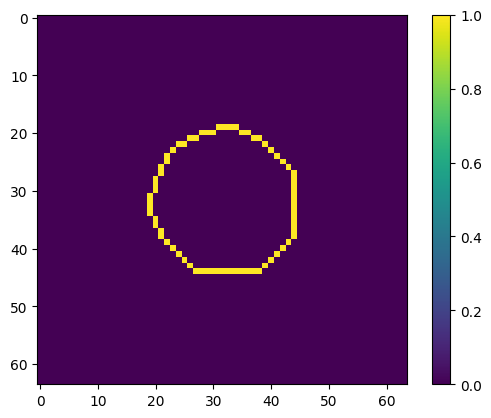

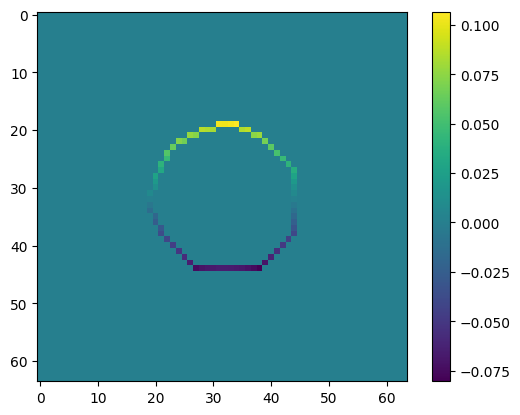

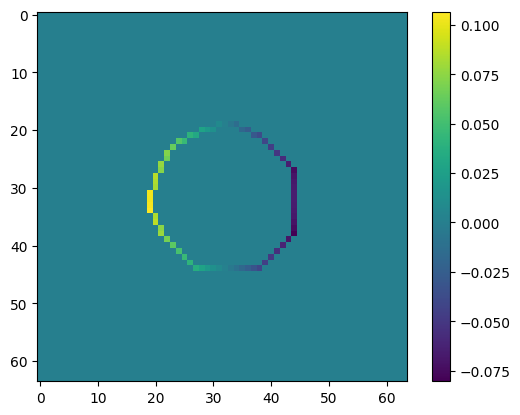

100%|██████████| 1000/1000 [00:11<00:00, 88.05it/s]


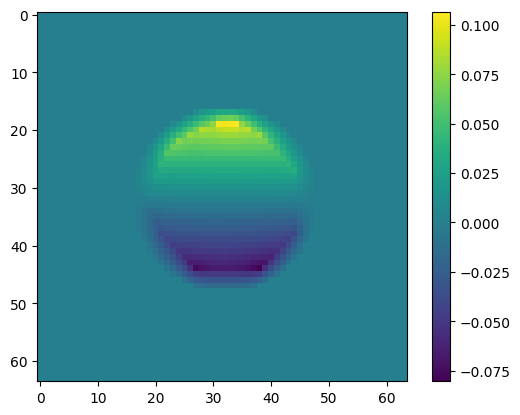

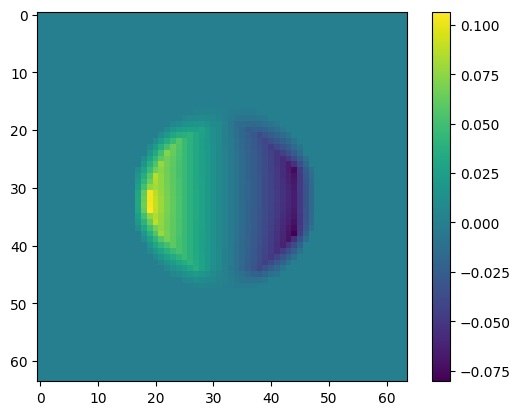

100%|██████████| 1000/1000 [00:11<00:00, 90.23it/s]


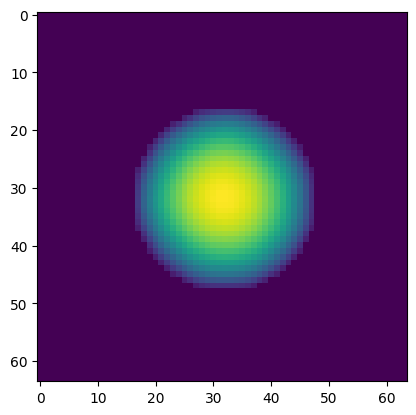

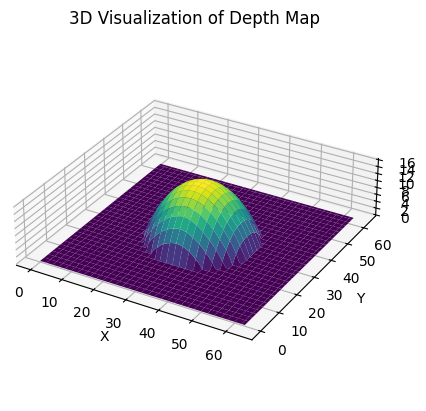

Mean Absolute Error (MAE): 3.789900647648035
Root Mean Squared Error (RMSE): 9.286424889975082
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.440320618157292


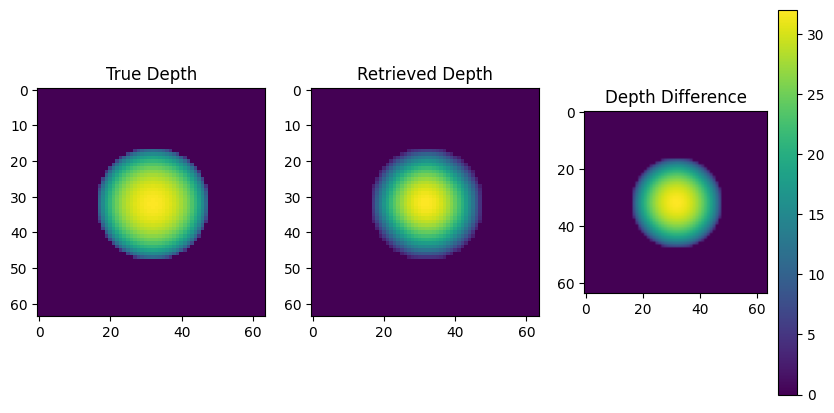

In [ ]:
P_a, Q_a, Z_a = SFS(1, 16, 0, 0, 0, 100)

B part

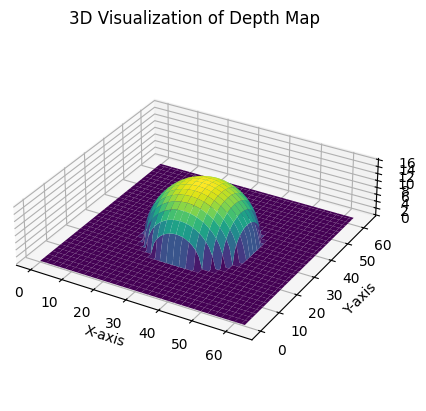

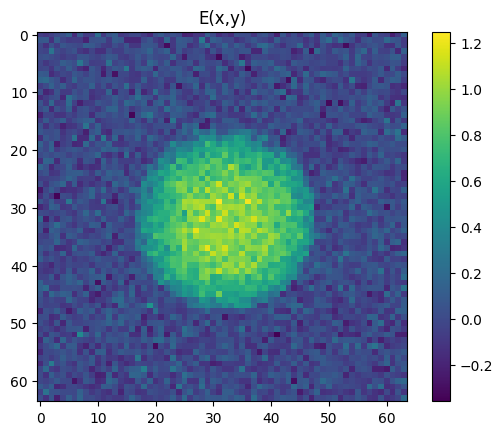

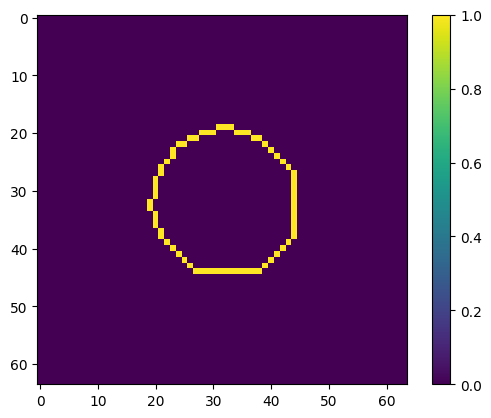

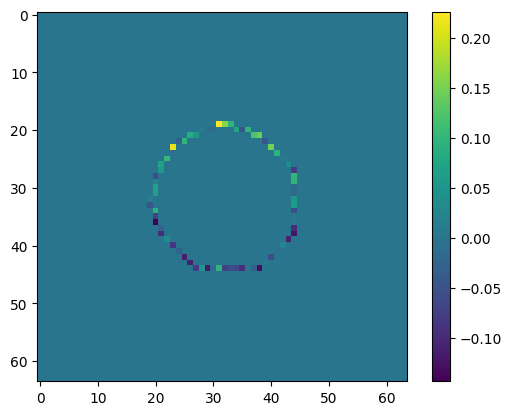

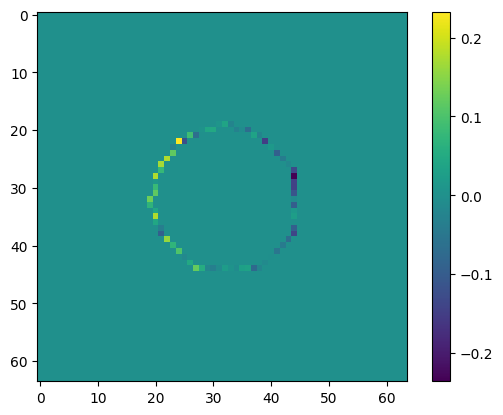

100%|██████████| 1000/1000 [00:30<00:00, 32.85it/s]


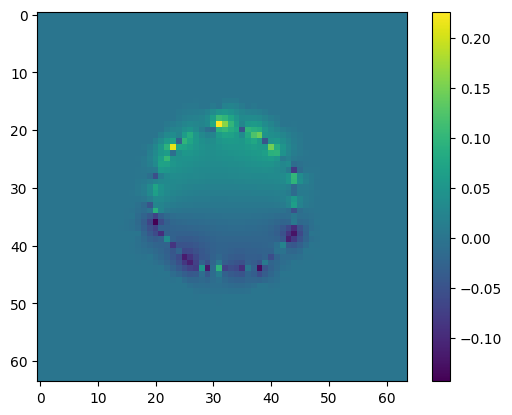

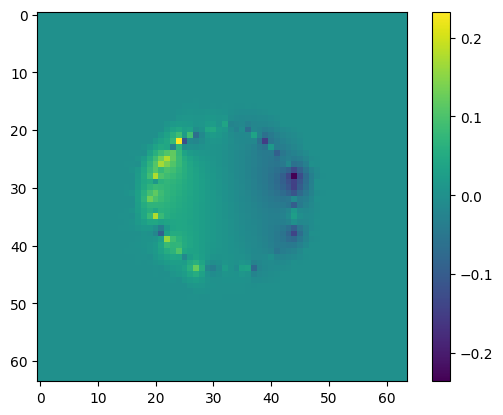

100%|██████████| 1000/1000 [00:16<00:00, 59.65it/s]


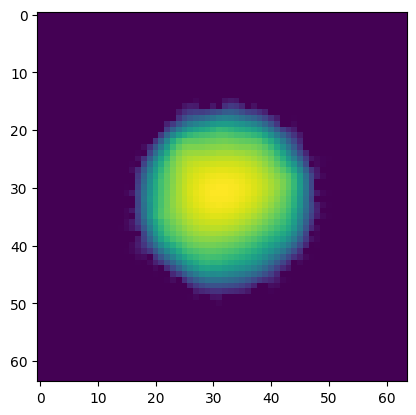

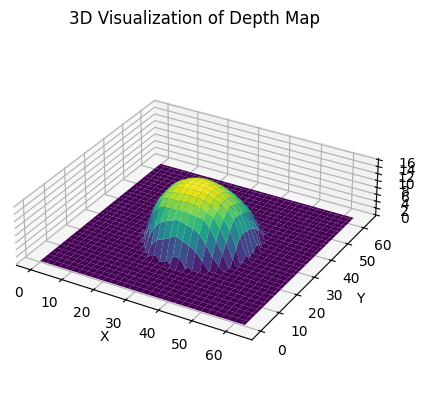

Mean Absolute Error (MAE): 4.093551063528453
Root Mean Squared Error (RMSE): 9.834383412647991
Maximum Absolute Error: 31.959395814958192
Relative Root Mean Squared Error (rel_RMSE): 4.702327962743273


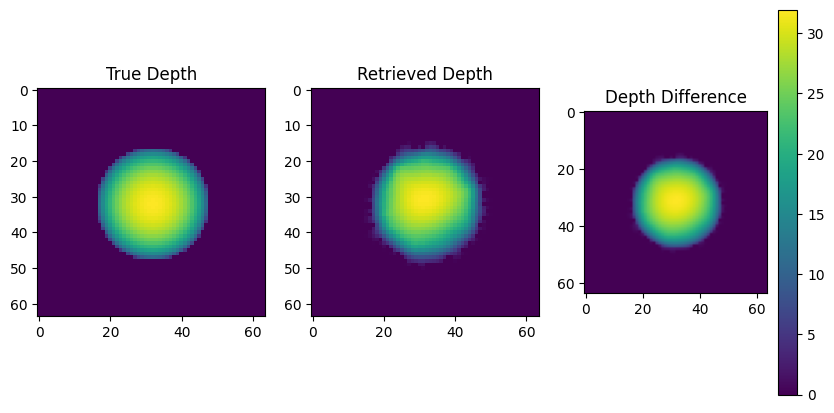

In [ ]:
P_b01, Q_b01, Z_b01 = SFS(1, 16, 0, 0, 0.1, 100)

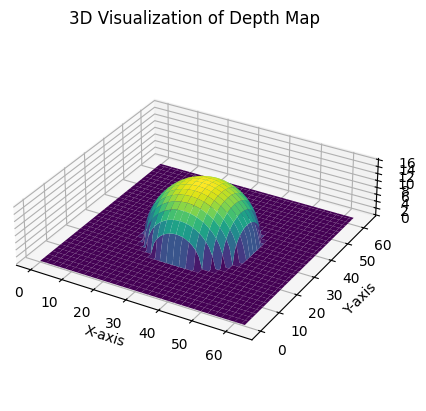

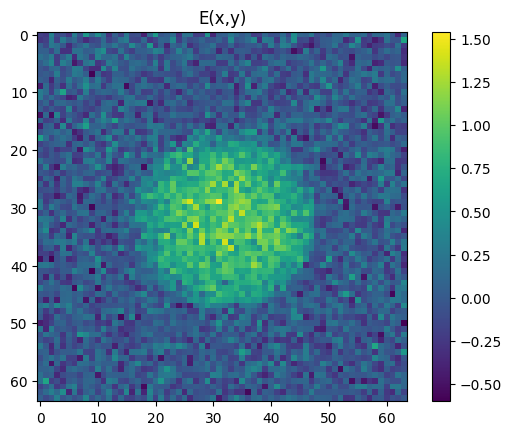

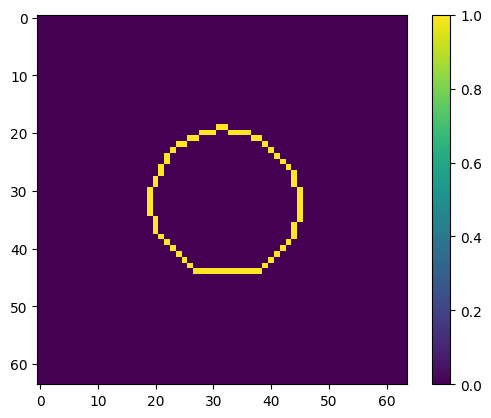

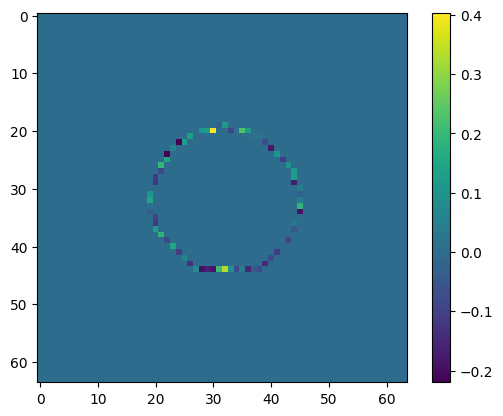

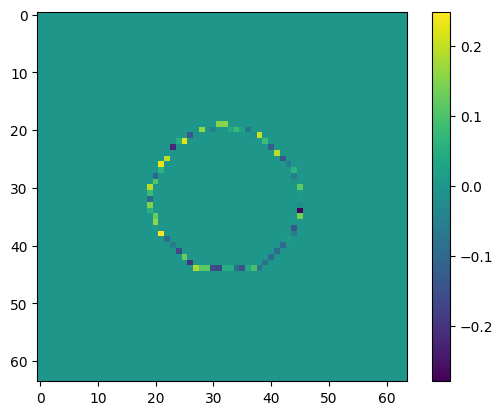

100%|██████████| 1000/1000 [00:30<00:00, 32.86it/s]


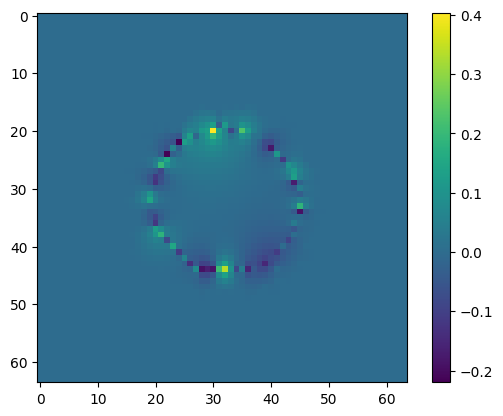

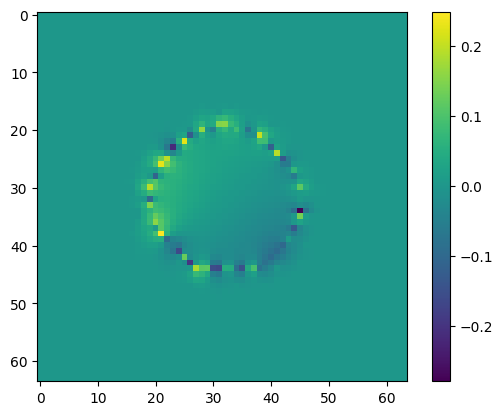

100%|██████████| 1000/1000 [00:19<00:00, 50.34it/s]


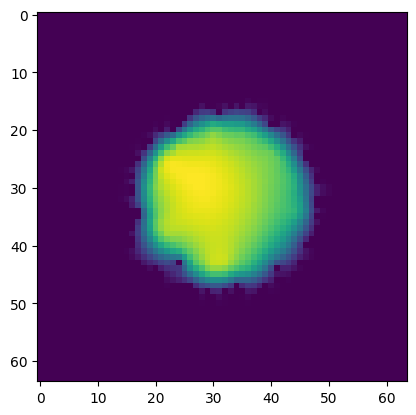

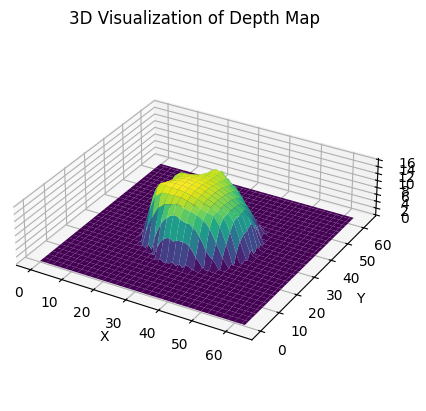

Mean Absolute Error (MAE): 4.1887076403579435
Root Mean Squared Error (RMSE): 10.079196916607934
Maximum Absolute Error: 31.604327875615866
Relative Root Mean Squared Error (rel_RMSE): 4.819385976146274


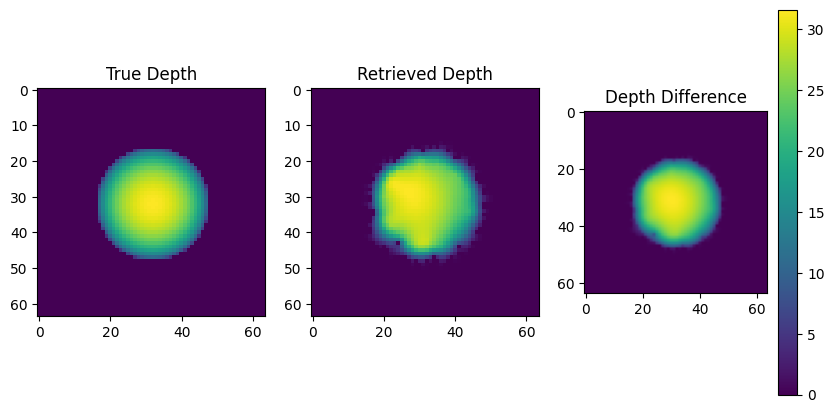

In [ ]:
P_b1, Q_b1, Z_b1 = SFS(1, 16, 0, 0, 0.2, 100)

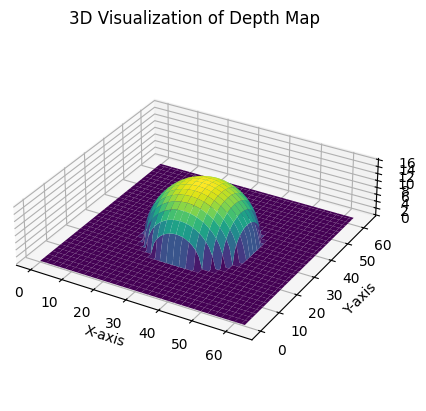

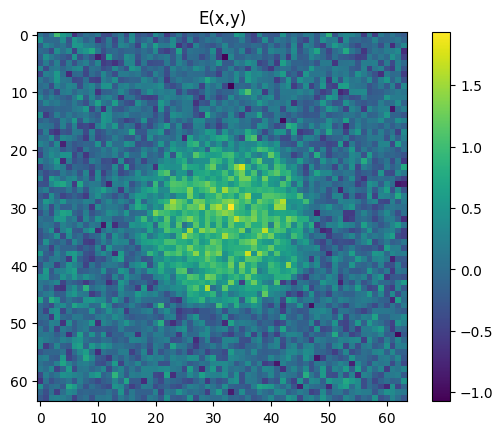

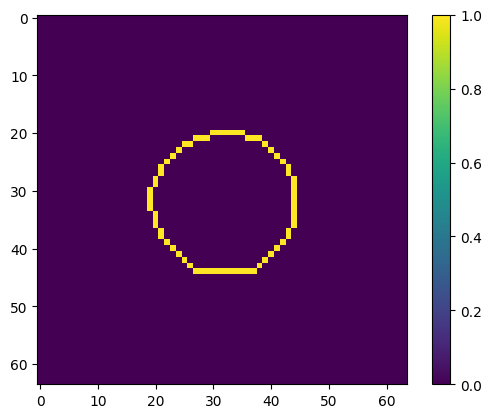

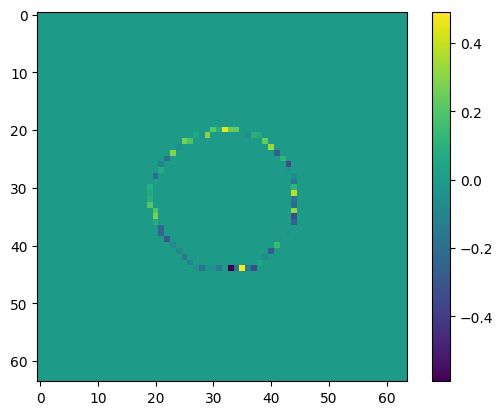

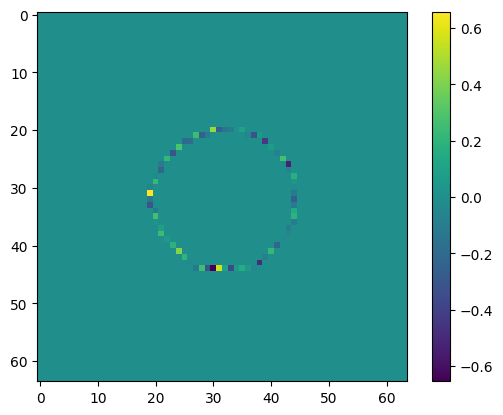

100%|██████████| 1000/1000 [00:31<00:00, 31.58it/s]


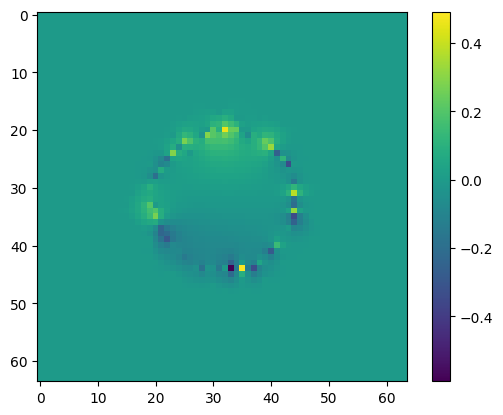

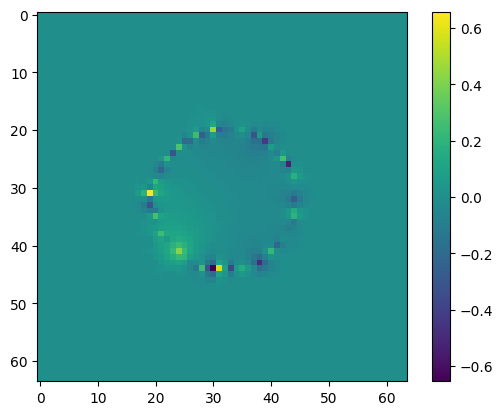

100%|██████████| 1000/1000 [00:15<00:00, 64.73it/s]


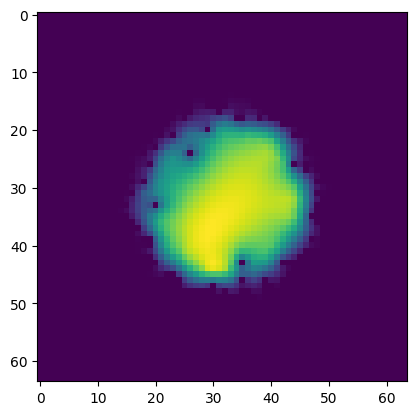

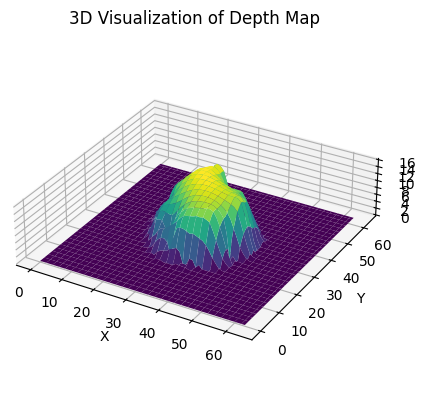

Mean Absolute Error (MAE): 3.9271265787027447
Root Mean Squared Error (RMSE): 9.622260414622223
Maximum Absolute Error: 31.67305527130813
Relative Root Mean Squared Error (rel_RMSE): 4.600900973037476


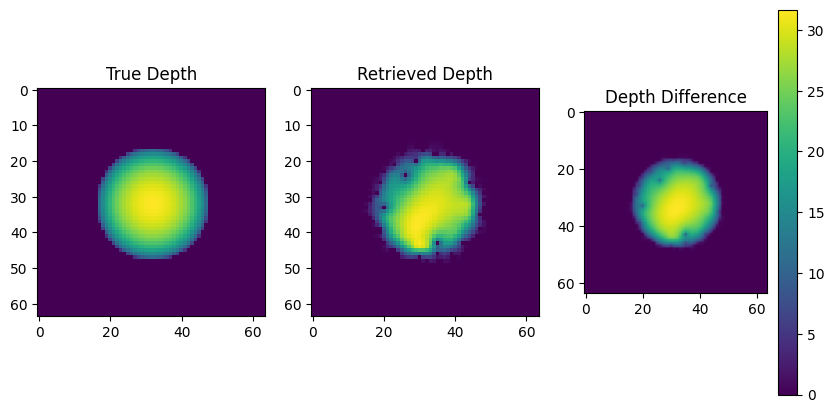

In [ ]:
P_b1, Q_b1, Z_b1 = SFS(1, 16, 0, 0, 0.3, 100)

C part

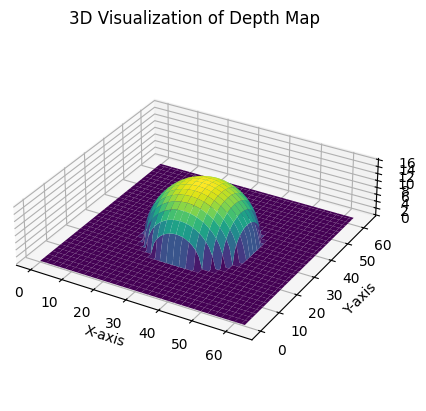

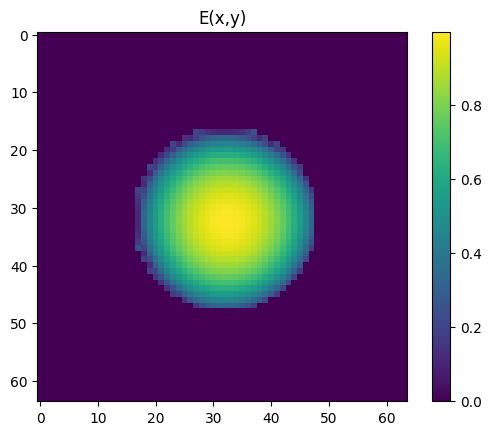

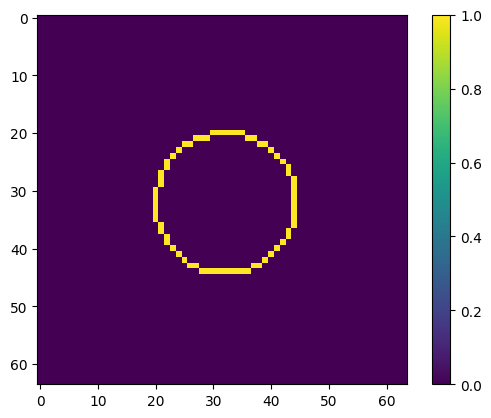

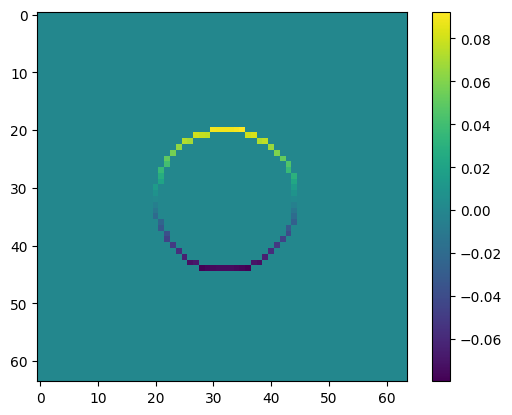

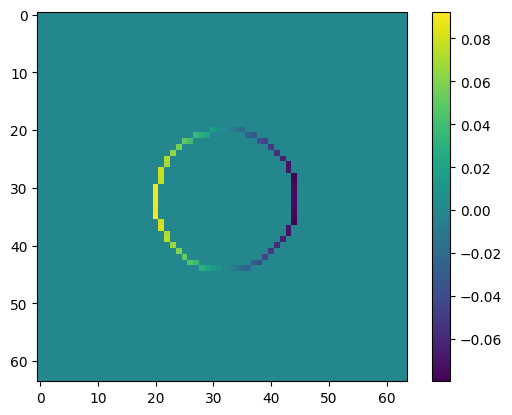

100%|██████████| 1000/1000 [00:11<00:00, 84.20it/s]


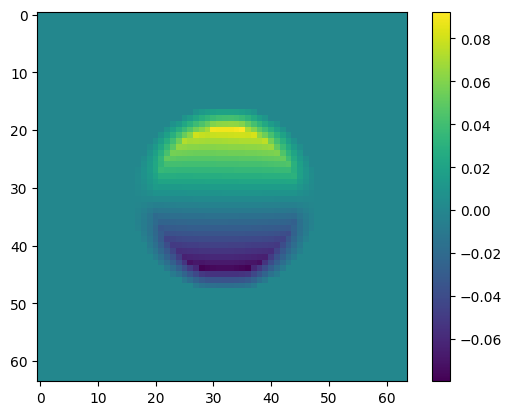

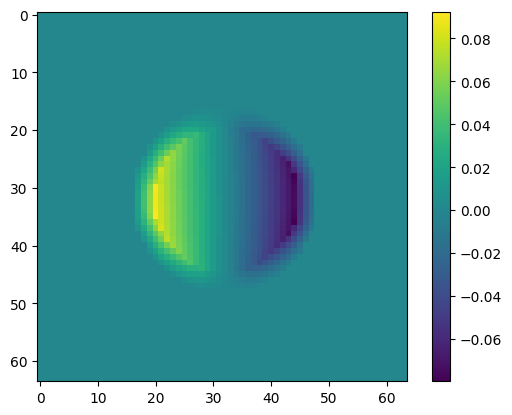

100%|██████████| 1000/1000 [00:11<00:00, 89.86it/s]


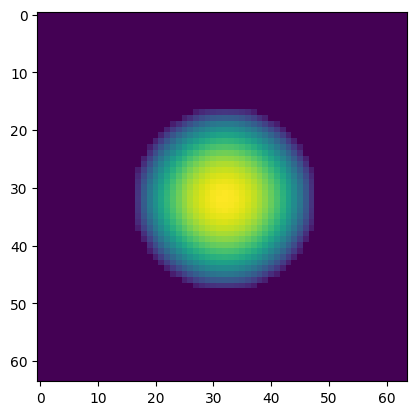

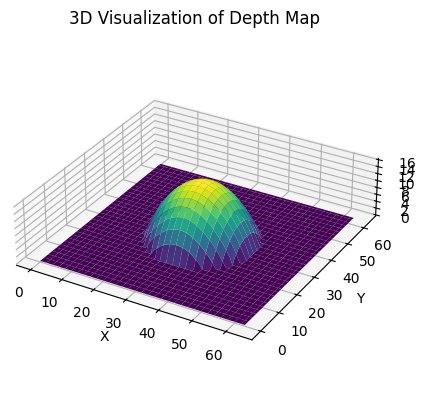

Mean Absolute Error (MAE): 3.776711311985215
Root Mean Squared Error (RMSE): 9.264348664699387
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.429764831681425


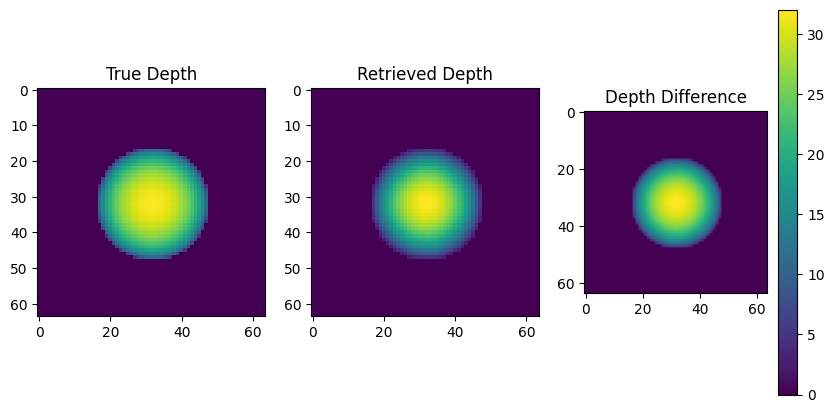

In [ ]:
P_b012, Q_b012, Z_b012 = SFS(1.25, 16, 0, 0, 0, 100)

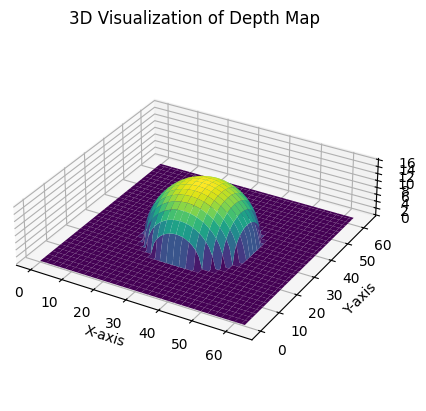

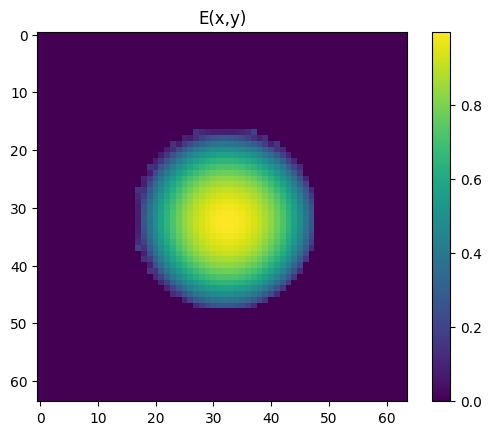

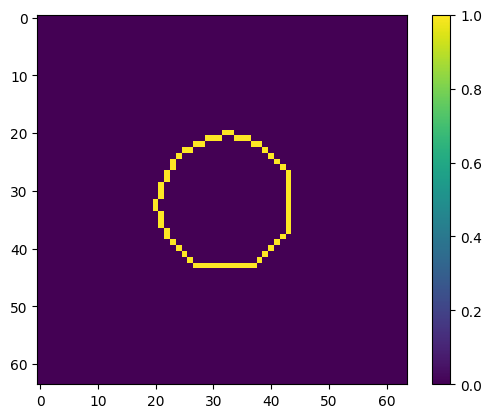

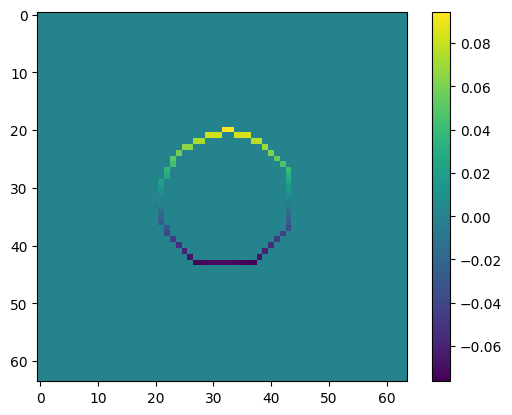

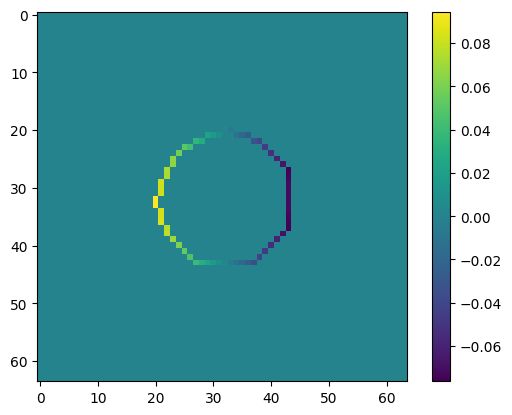

100%|██████████| 1000/1000 [00:11<00:00, 85.58it/s]


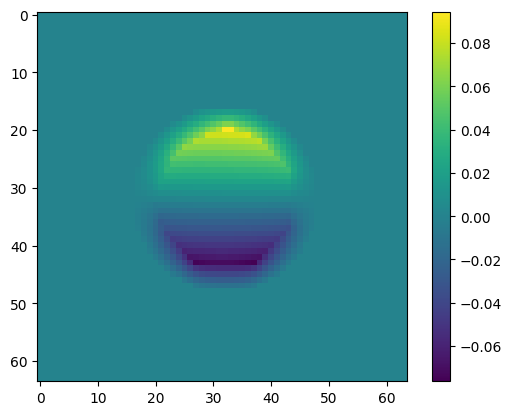

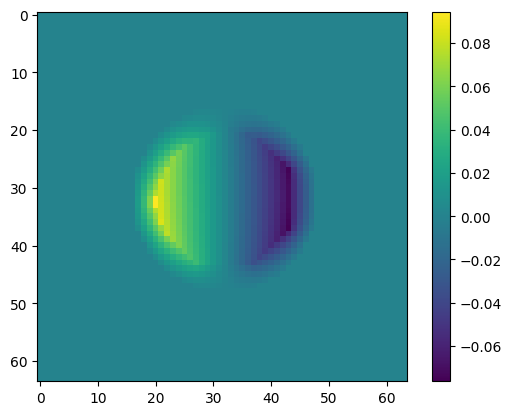

100%|██████████| 1000/1000 [00:11<00:00, 90.15it/s]


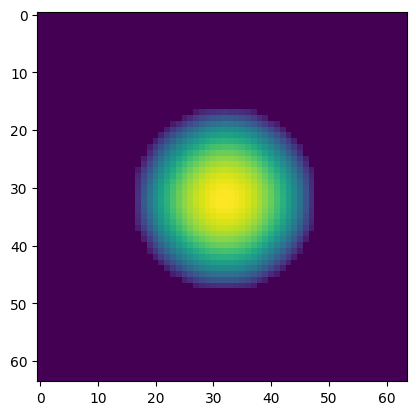

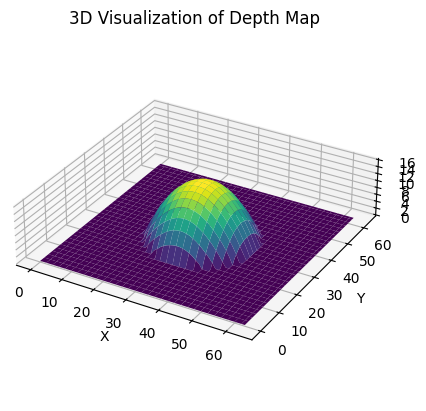

Mean Absolute Error (MAE): 3.7467835082006147
Root Mean Squared Error (RMSE): 9.209333321473935
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.403459147229846


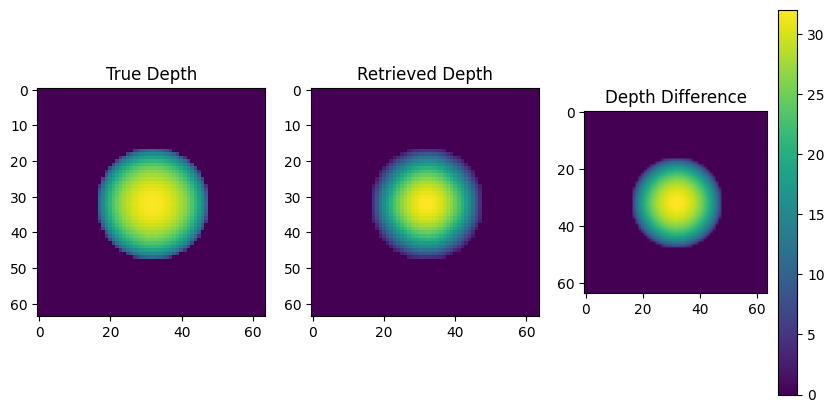

In [ ]:
P_b014, Q_b014, Z_b014 = SFS(1.5, 16, 0, 0, 0, 100)

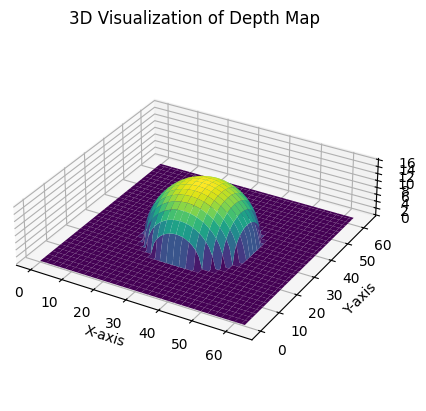

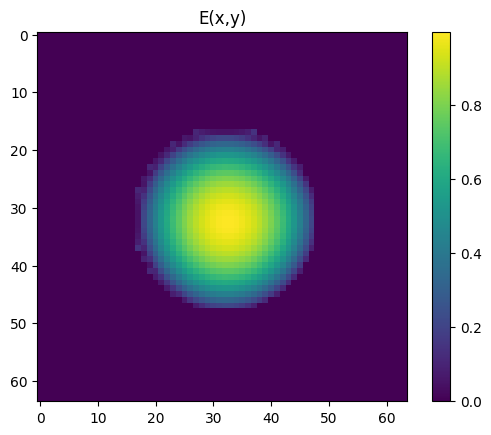

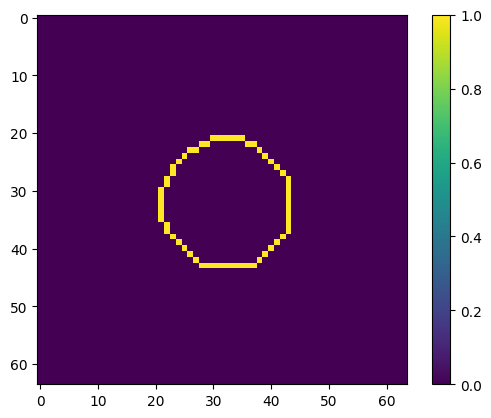

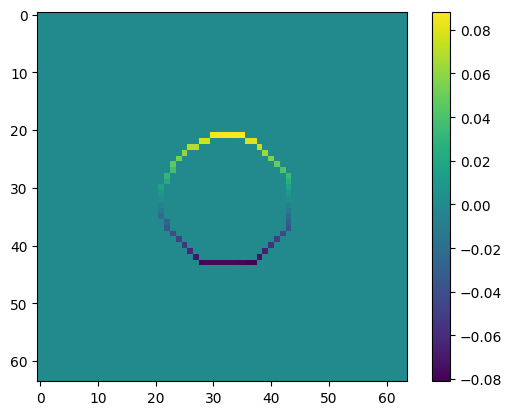

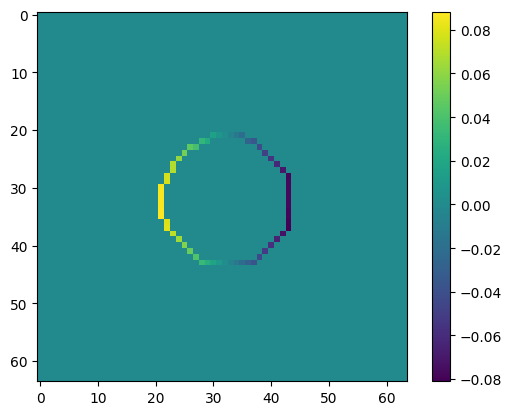

100%|██████████| 1000/1000 [00:11<00:00, 87.09it/s]


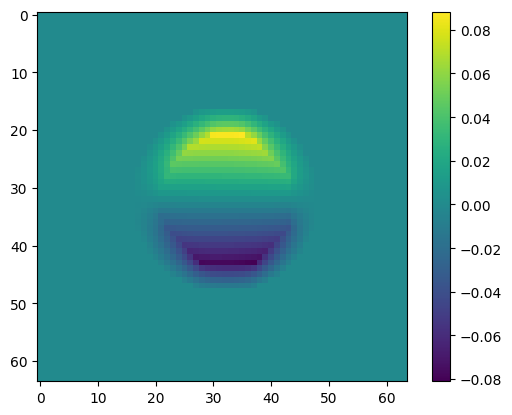

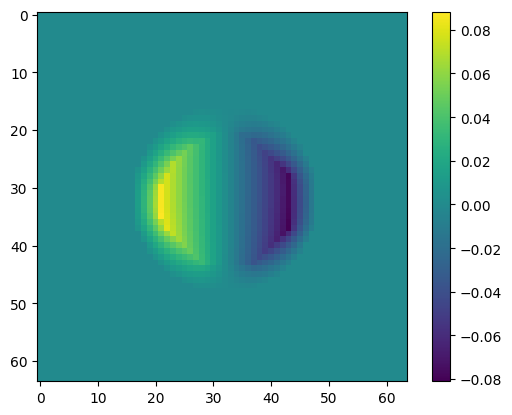

100%|██████████| 1000/1000 [00:11<00:00, 89.05it/s]


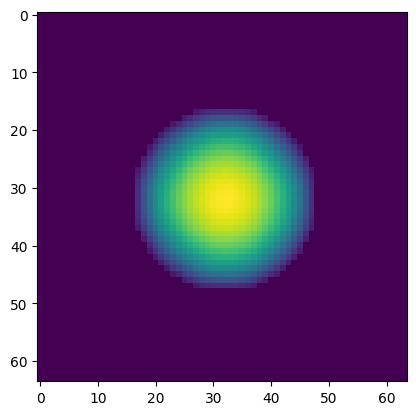

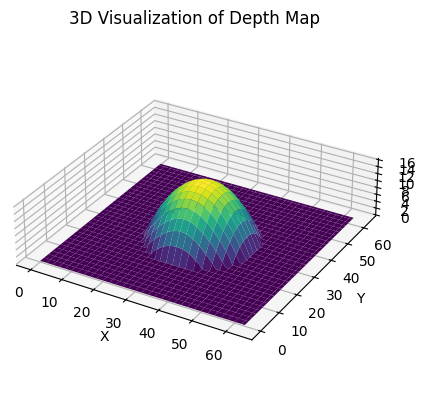

Mean Absolute Error (MAE): 3.729157277805956
Root Mean Squared Error (RMSE): 9.176415230096612
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.387719303147232


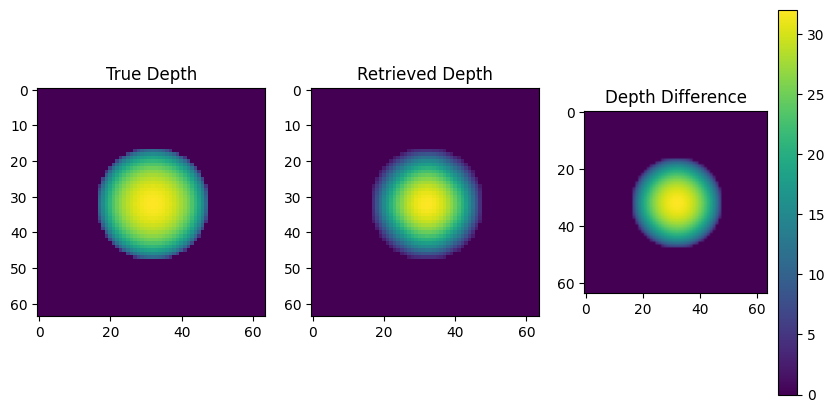

In [ ]:
P_b016, Q_b016, Z_b016 = SFS(1.75, 16, 0, 0, 0, 100)

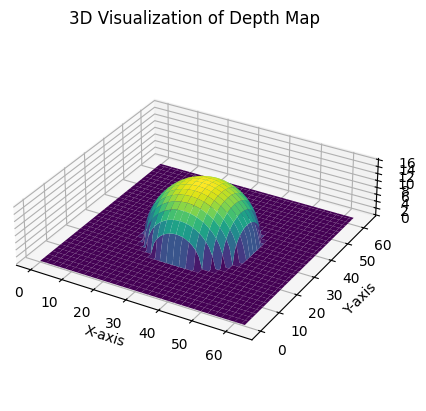

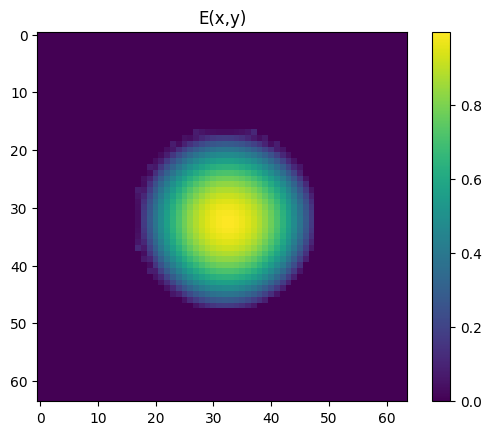

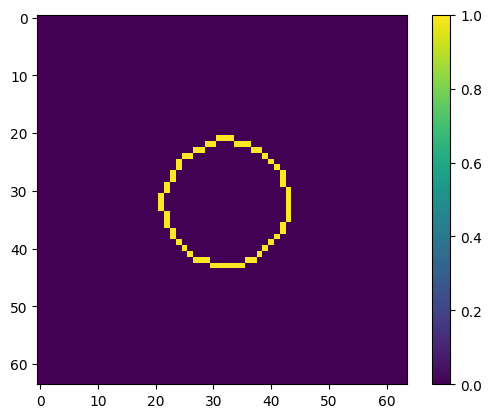

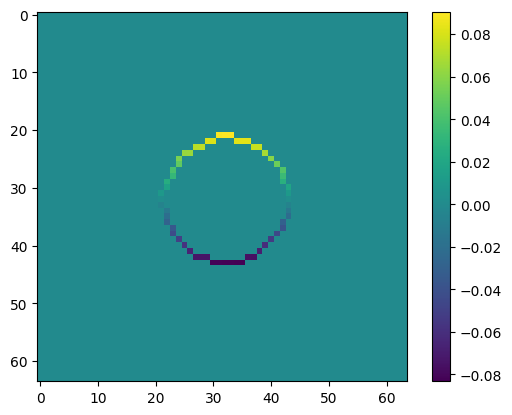

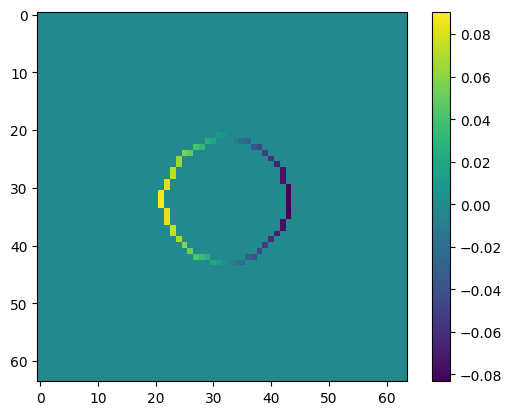

100%|██████████| 1000/1000 [00:11<00:00, 88.02it/s]


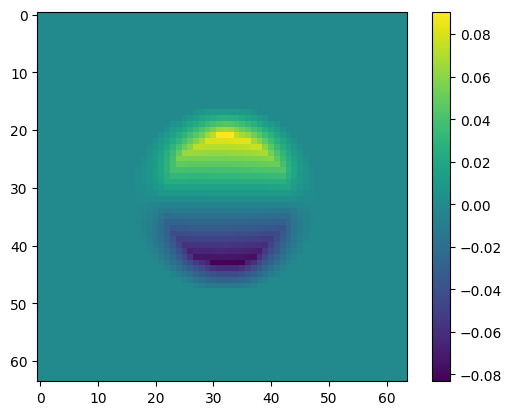

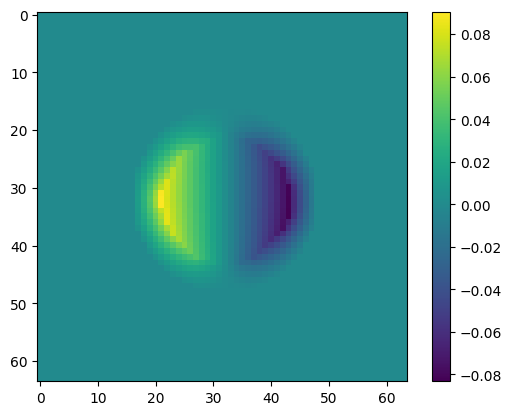

100%|██████████| 1000/1000 [00:10<00:00, 91.14it/s]


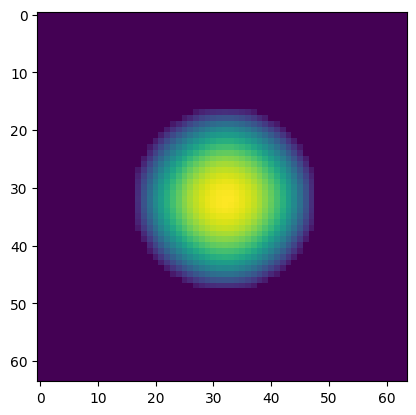

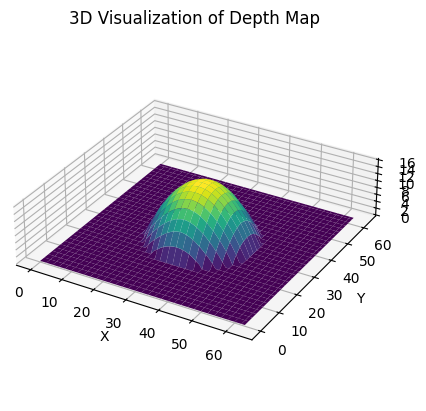

Mean Absolute Error (MAE): 3.709328003268232
Root Mean Squared Error (RMSE): 9.13817725766023
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.36943574845127


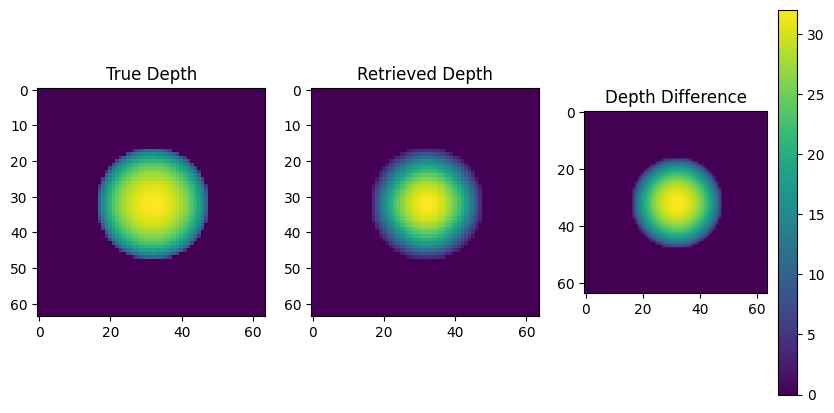

In [ ]:
P_b018, Q_b018, Z_b018 = SFS(2, 16, 0, 0, 0, 100)

D part

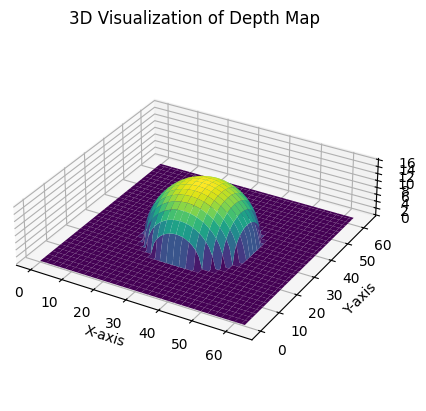

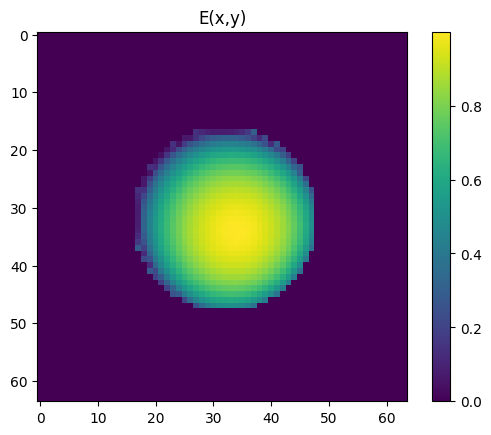

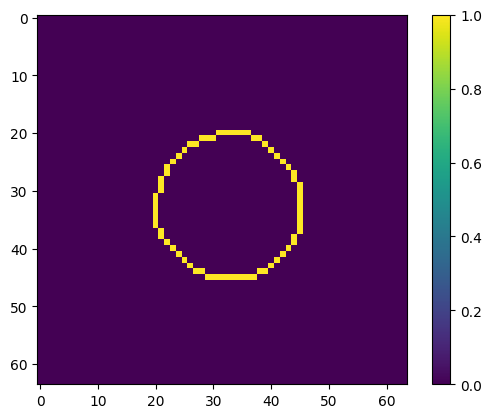

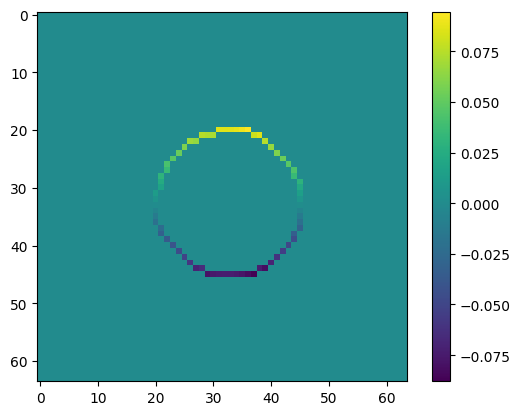

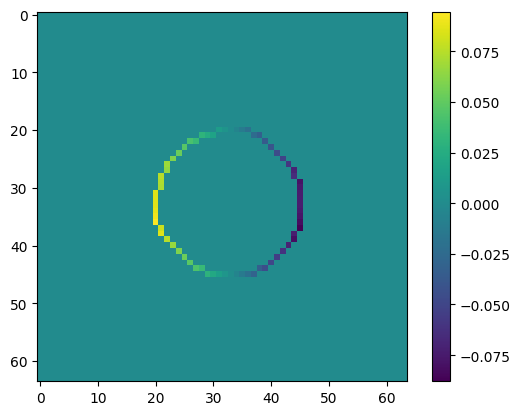

100%|██████████| 1000/1000 [00:11<00:00, 87.94it/s]


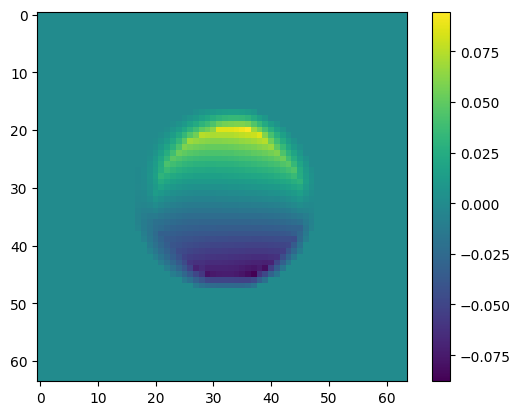

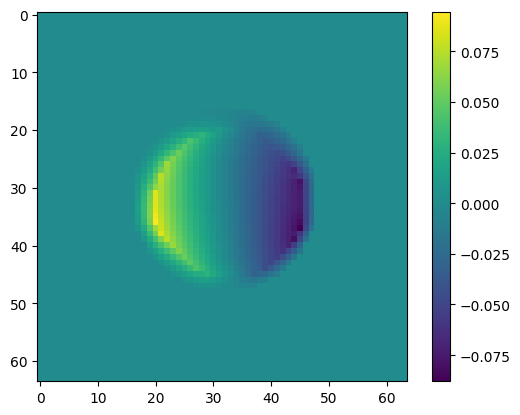

100%|██████████| 1000/1000 [00:11<00:00, 89.73it/s]


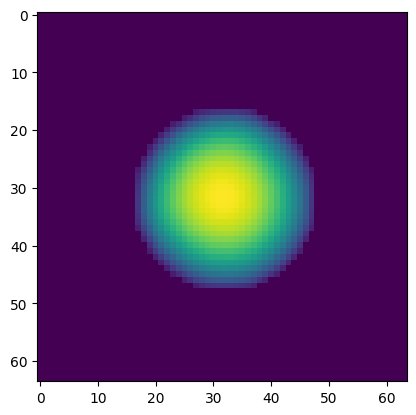

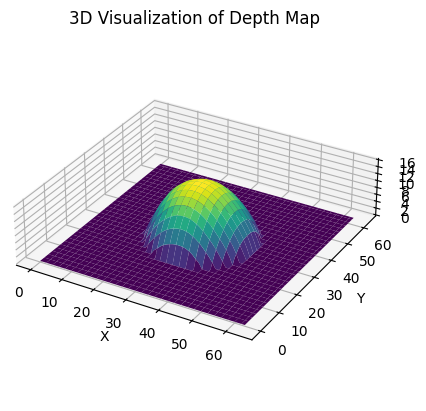

Mean Absolute Error (MAE): 3.7994477399812023
Root Mean Squared Error (RMSE): 9.311590075482675
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.452353396475431


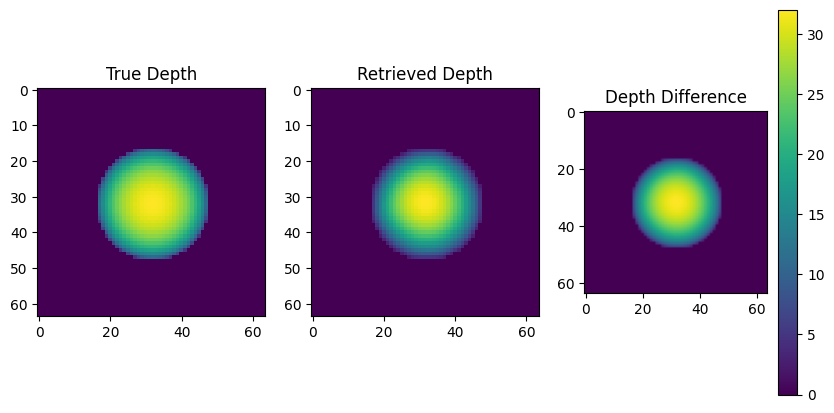

In [ ]:
P_c0, Q_c0, Z_c0 = SFS(1, 16, 0.1, 0.1, 0, 100)

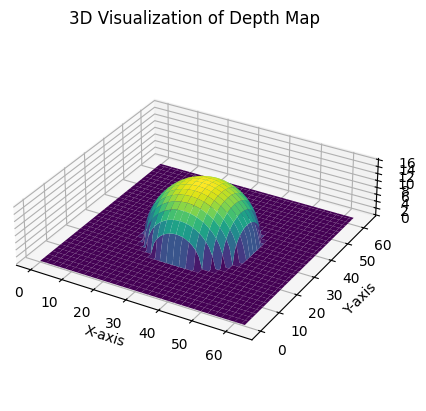

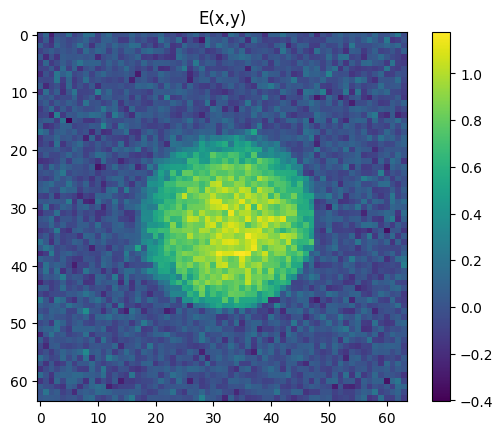

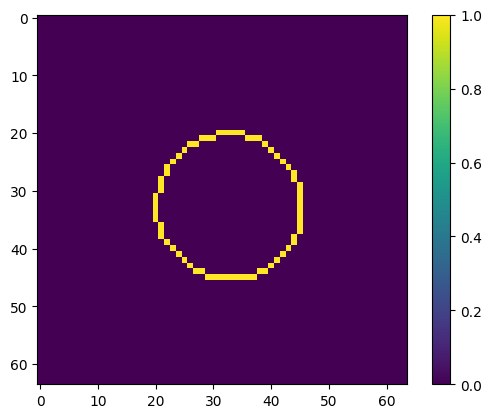

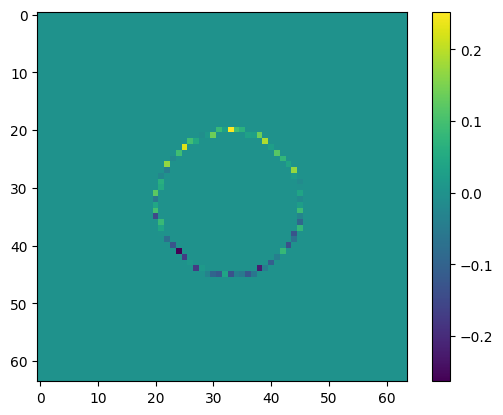

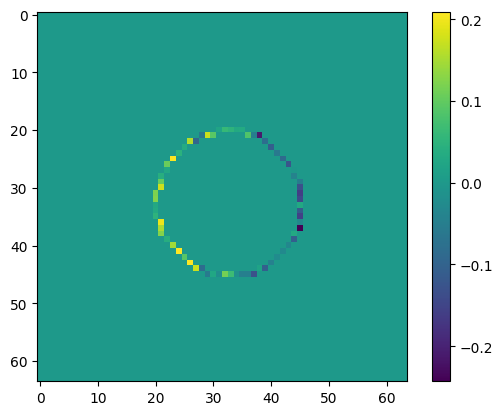

100%|██████████| 1000/1000 [00:31<00:00, 32.15it/s]


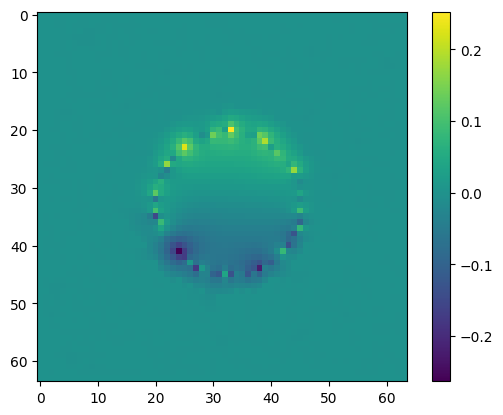

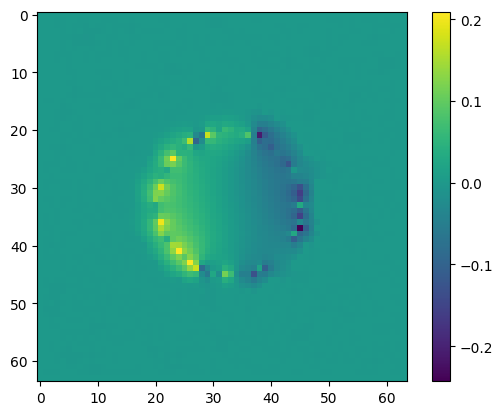

100%|██████████| 1000/1000 [00:15<00:00, 64.97it/s]


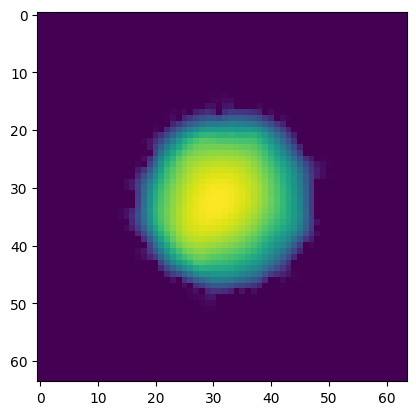

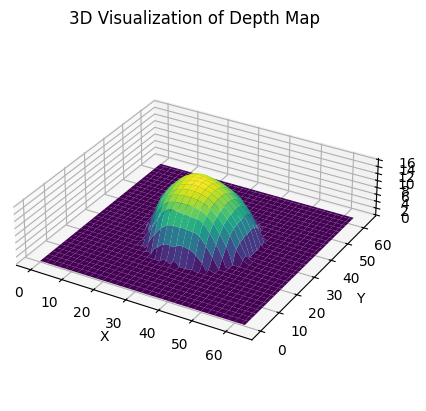

Mean Absolute Error (MAE): 4.017463248976409
Root Mean Squared Error (RMSE): 9.70613040606865
Maximum Absolute Error: 31.968719422671313
Relative Root Mean Squared Error (rel_RMSE): 4.64100355898164


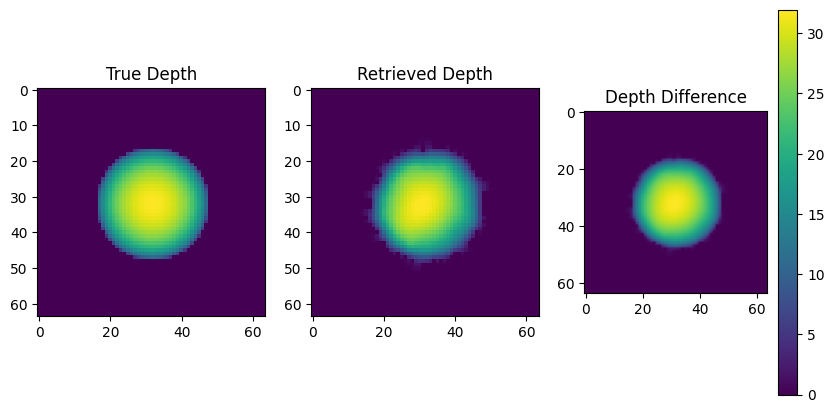

In [ ]:
P_c1, Q_c1, Z_c1 = SFS(1, 16, 0.1, 0.1, 0.1, 100)

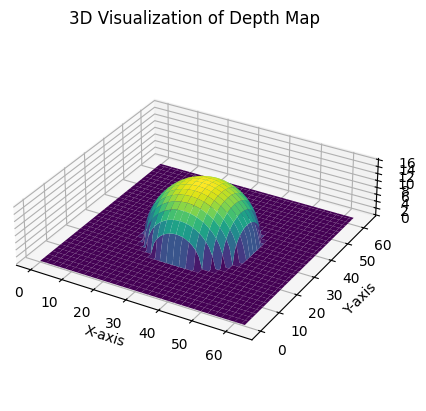

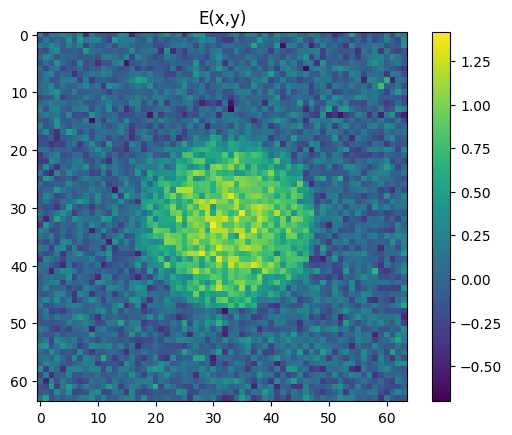

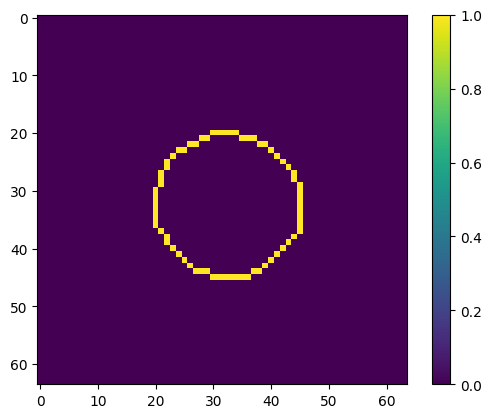

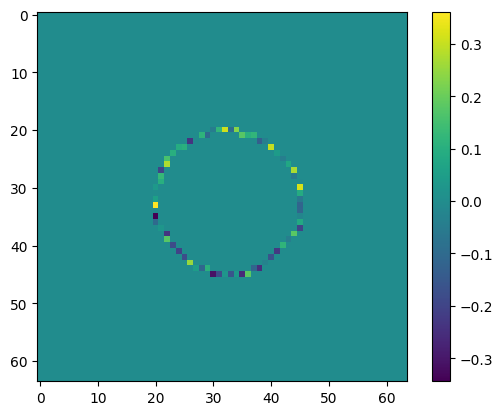

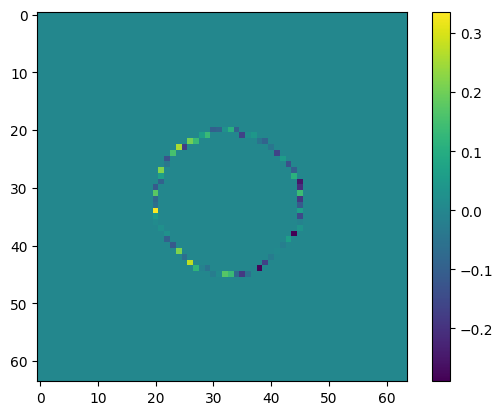

100%|██████████| 1000/1000 [00:31<00:00, 32.01it/s]


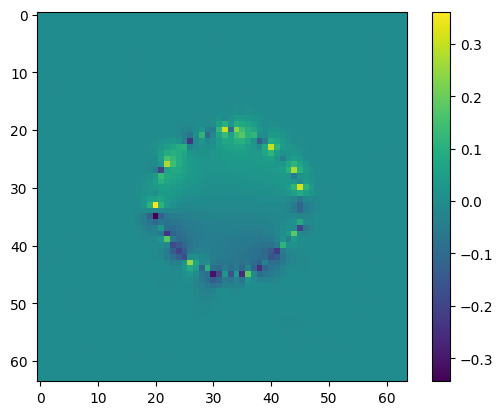

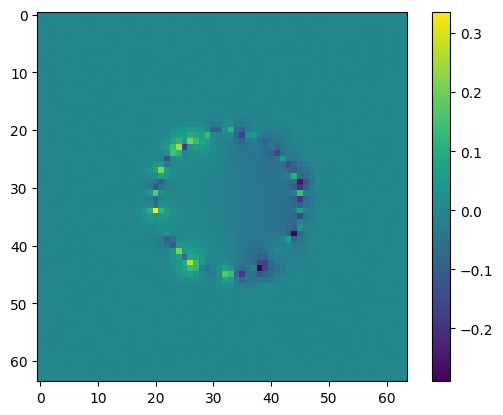

100%|██████████| 1000/1000 [00:15<00:00, 64.01it/s]


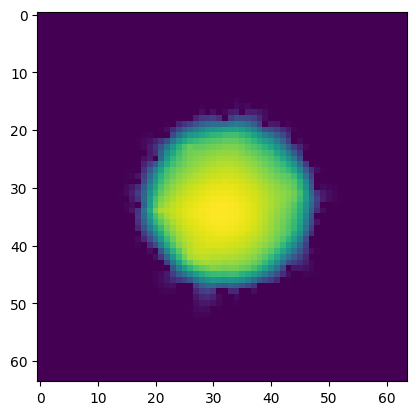

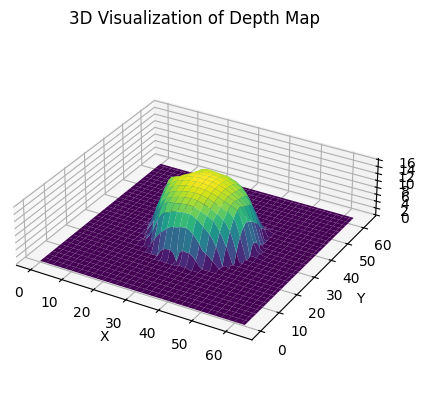

Mean Absolute Error (MAE): 4.150567295986288
Root Mean Squared Error (RMSE): 10.02465481603007
Maximum Absolute Error: 31.908900835145744
Relative Root Mean Squared Error (rel_RMSE): 4.793306573510396


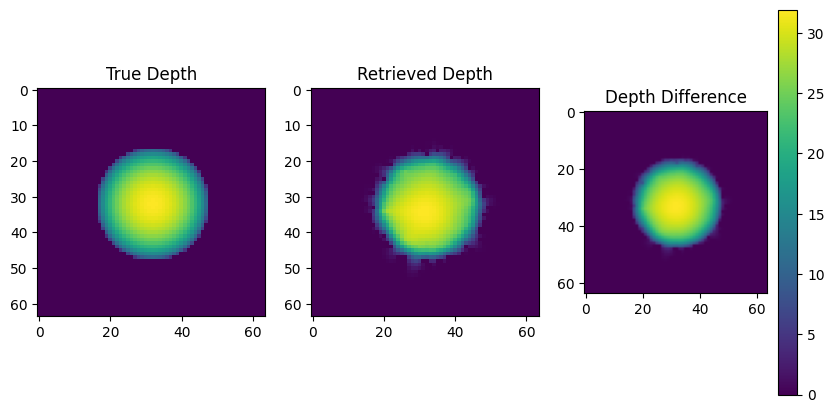

In [ ]:
P_c2, Q_c2, Z_c1 = SFS(1, 16, 0.1, 0.1, 0.2, 100)

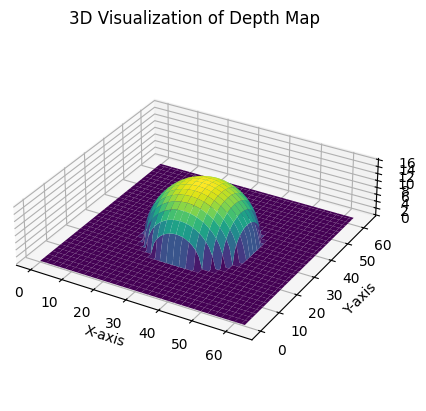

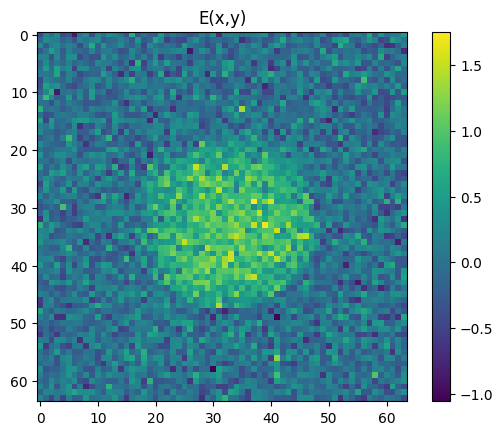

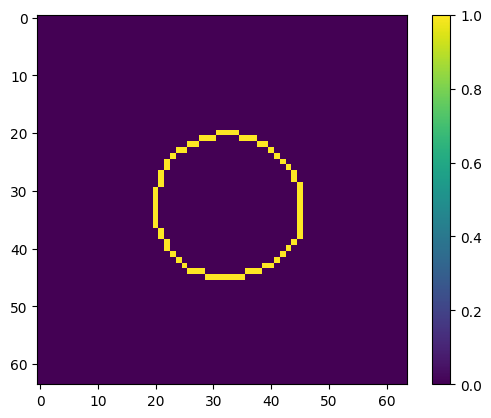

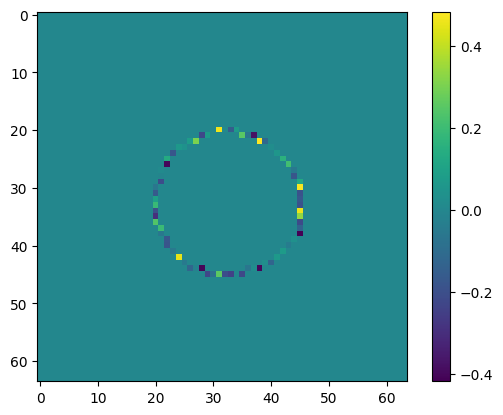

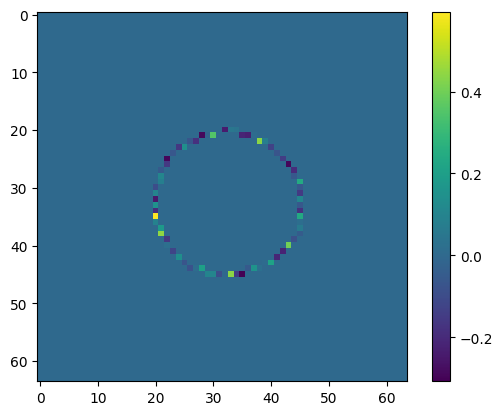

100%|██████████| 1000/1000 [00:31<00:00, 32.07it/s]


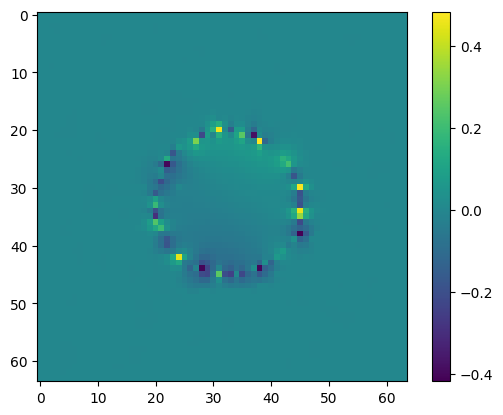

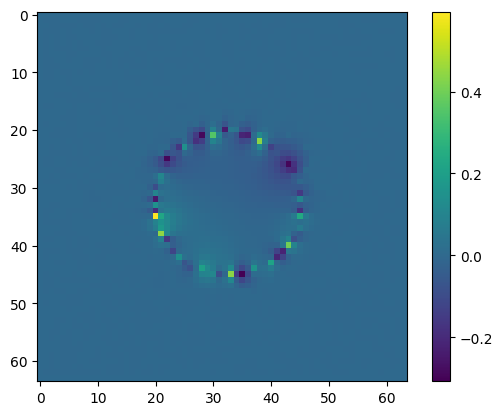

100%|██████████| 1000/1000 [00:15<00:00, 63.80it/s]


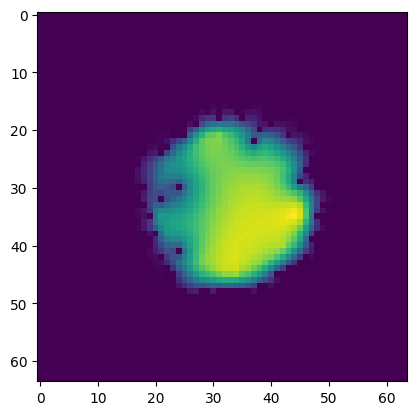

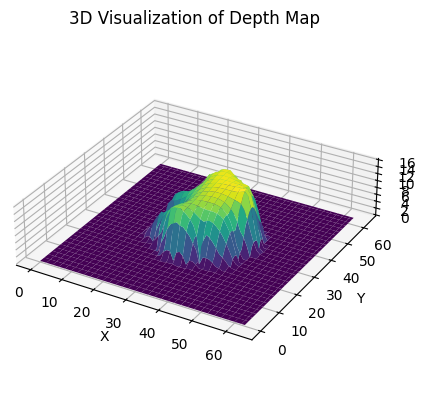

Mean Absolute Error (MAE): 3.8359481936321957
Root Mean Squared Error (RMSE): 9.353489636030334
Maximum Absolute Error: 30.193514462056832
Relative Root Mean Squared Error (rel_RMSE): 4.472387746055143


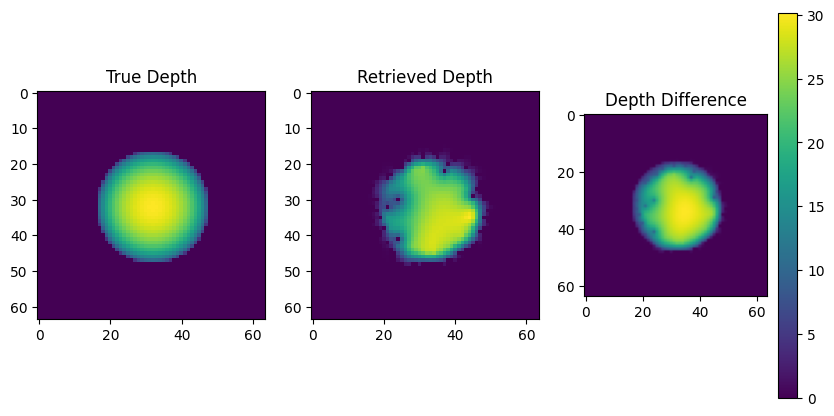

In [ ]:
P_c3, Q_c3, Z_c3 = SFS(1, 16, 0.1, 0.1, 0.3, 100)

E part

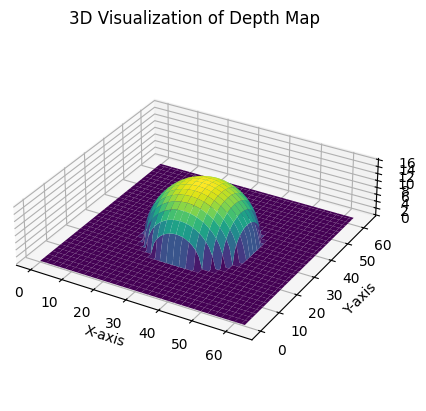

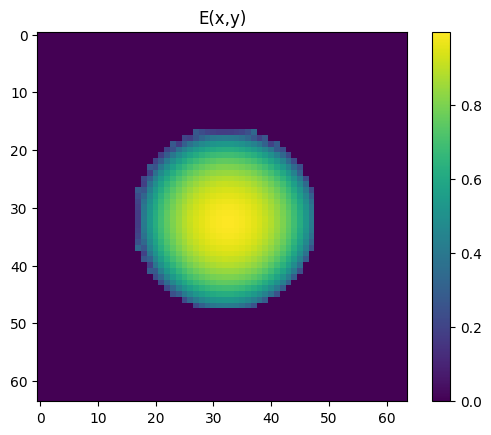

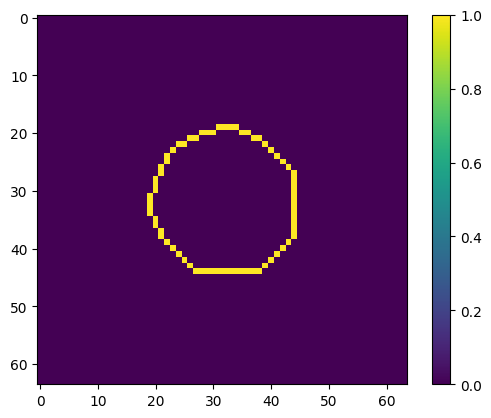

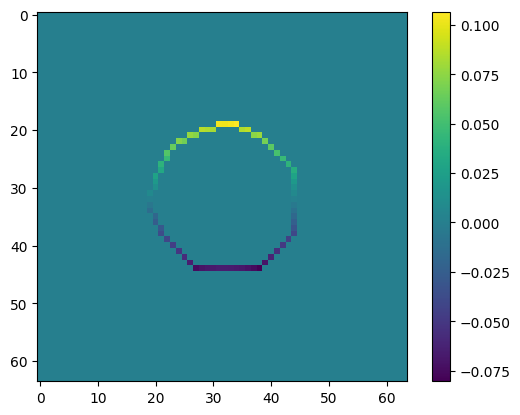

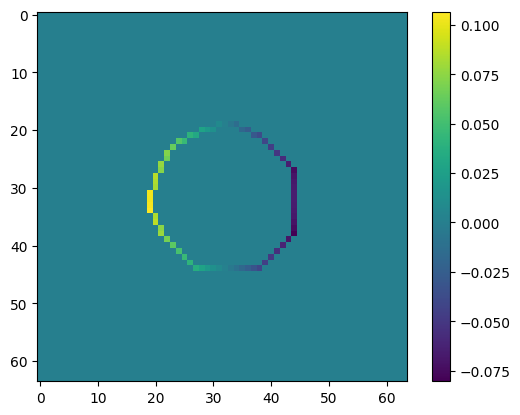

100%|██████████| 1000/1000 [00:11<00:00, 87.38it/s] 


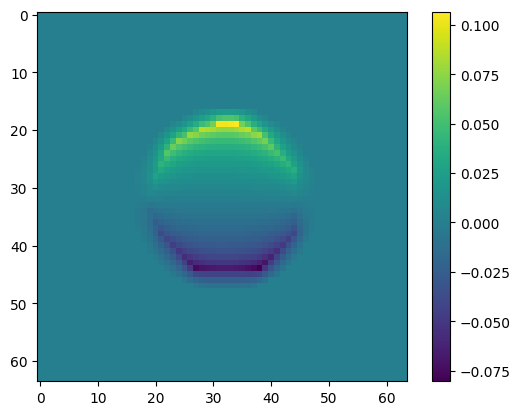

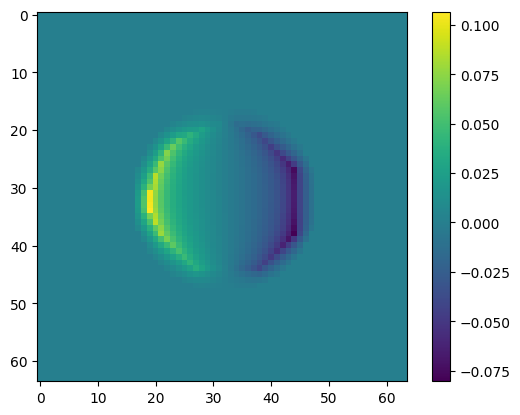

100%|██████████| 1000/1000 [00:10<00:00, 90.95it/s]


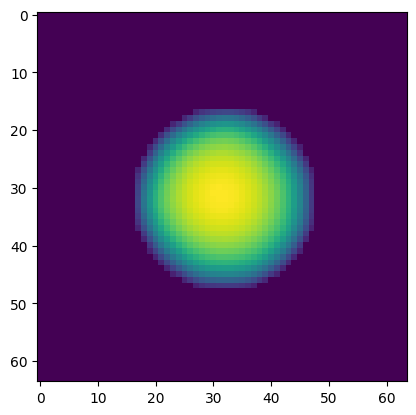

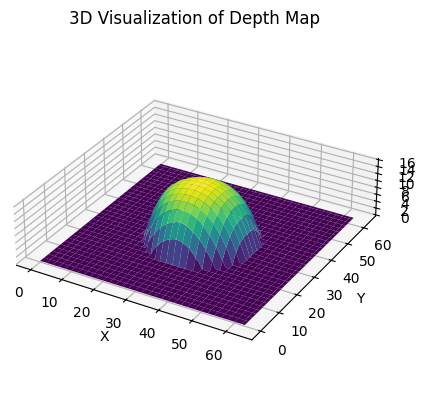

Mean Absolute Error (MAE): 3.9915568470571863
Root Mean Squared Error (RMSE): 9.721718532707092
Maximum Absolute Error: 31.985841750081853
Relative Root Mean Squared Error (rel_RMSE): 4.648457049526299


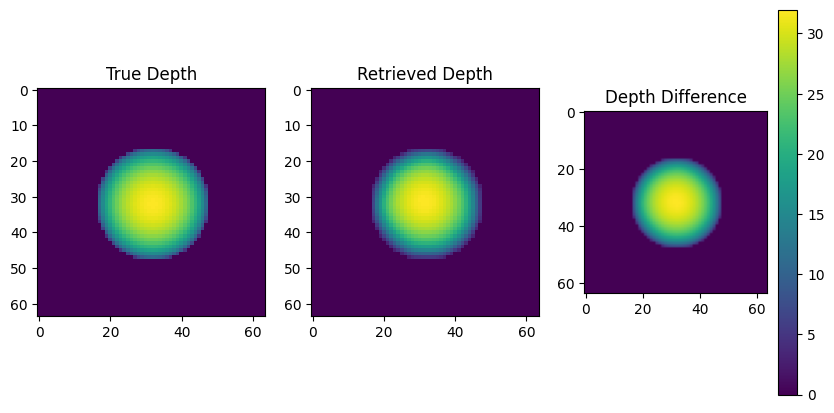

In [ ]:
P_d10, Q_d10, Z_d10 = SFS(1, 16, 0, 0, 0, 10)

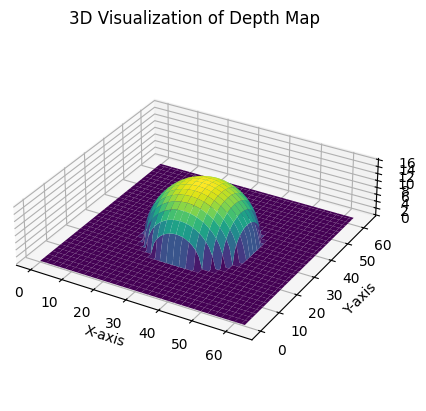

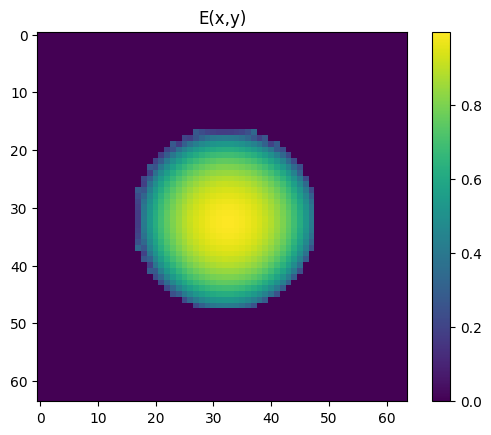

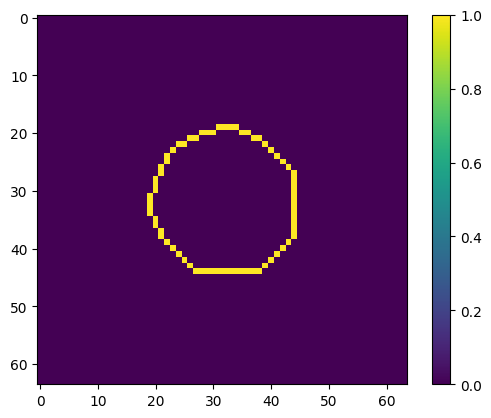

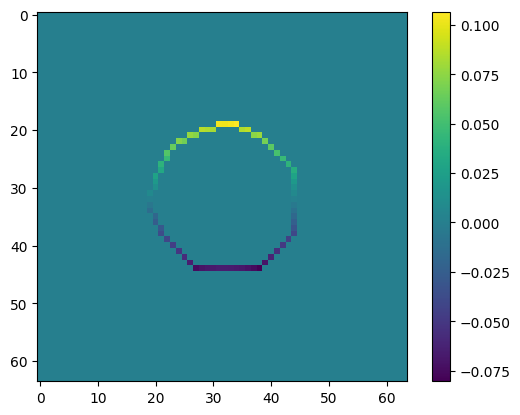

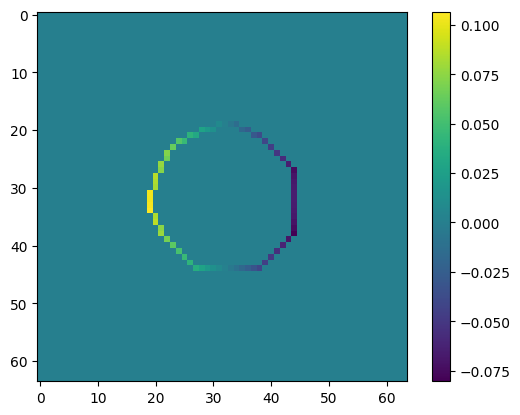

100%|██████████| 1000/1000 [00:11<00:00, 87.44it/s]


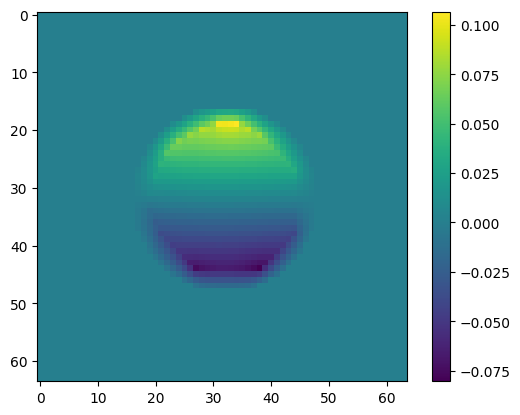

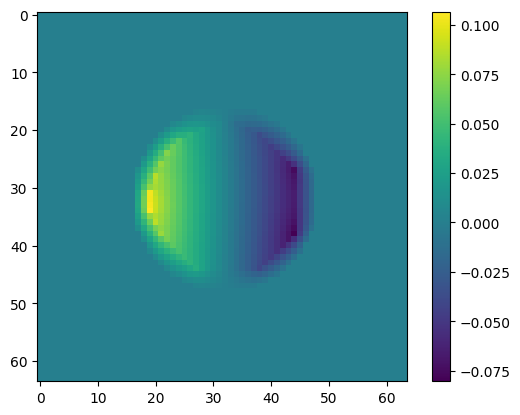

100%|██████████| 1000/1000 [00:11<00:00, 90.03it/s]


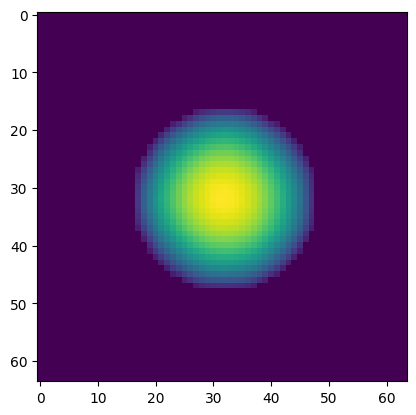

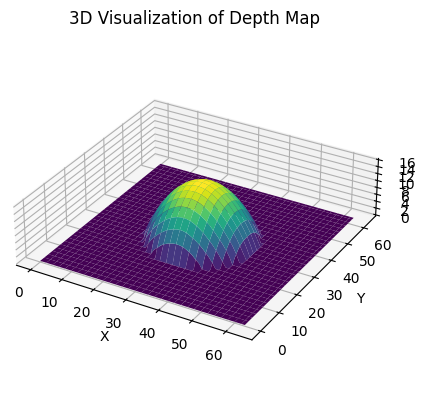

Mean Absolute Error (MAE): 3.764725350675154
Root Mean Squared Error (RMSE): 9.232241008025557
Maximum Absolute Error: 32.0
Relative Root Mean Squared Error (rel_RMSE): 4.414412498397232


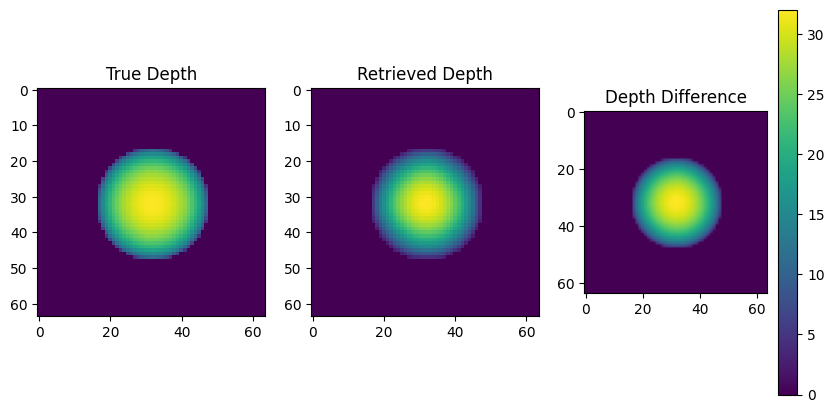

In [ ]:
P_d1000, Q_d1000, Z_d1000 = SFS(1, 16, 0, 0, 0, 1000)

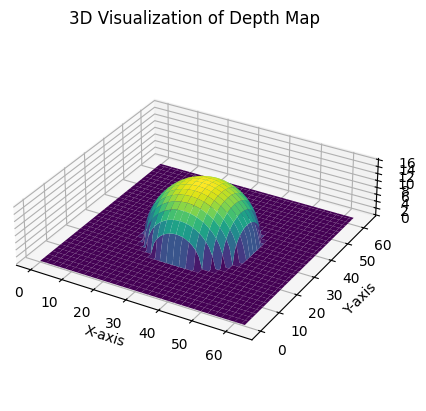

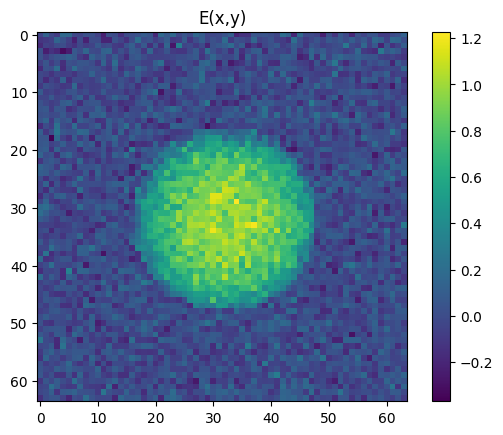

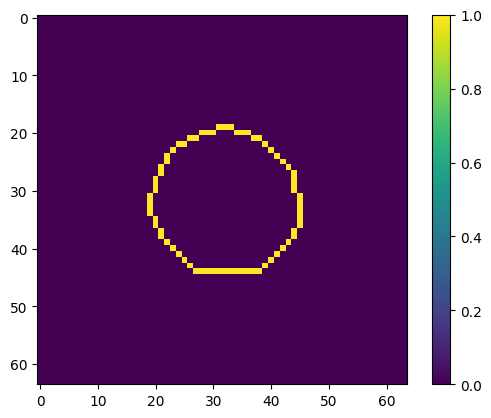

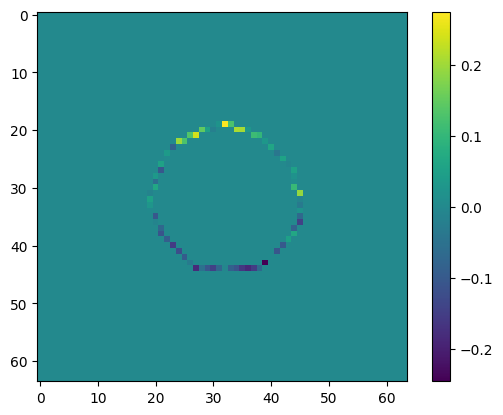

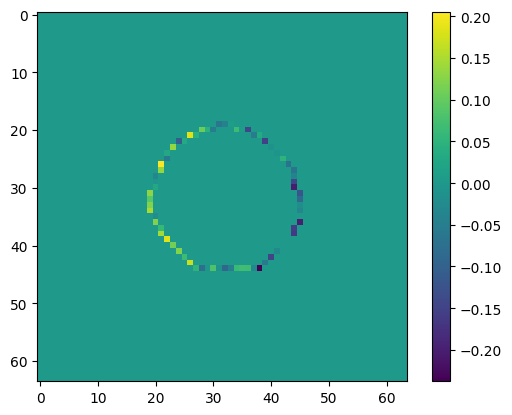

100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


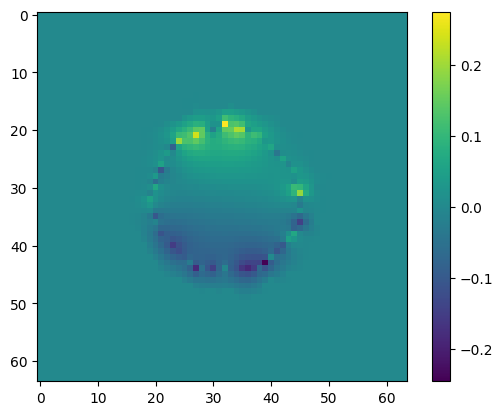

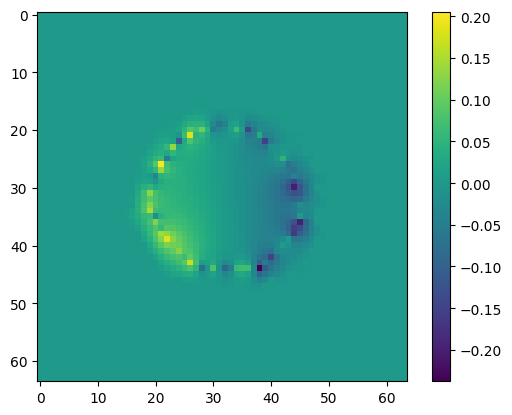

100%|██████████| 1000/1000 [00:15<00:00, 64.27it/s]


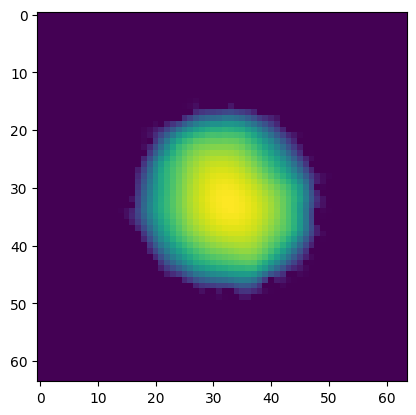

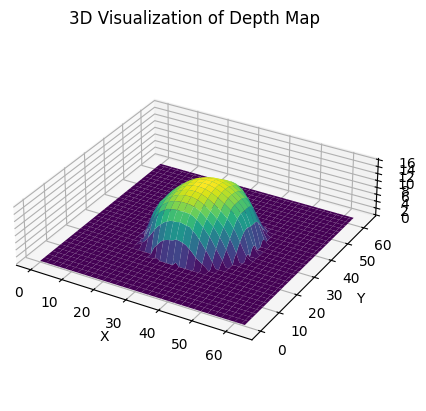

Mean Absolute Error (MAE): 4.051662212263317
Root Mean Squared Error (RMSE): 9.763014568709005
Maximum Absolute Error: 31.980529836209453
Relative Root Mean Squared Error (rel_RMSE): 4.668202822768423


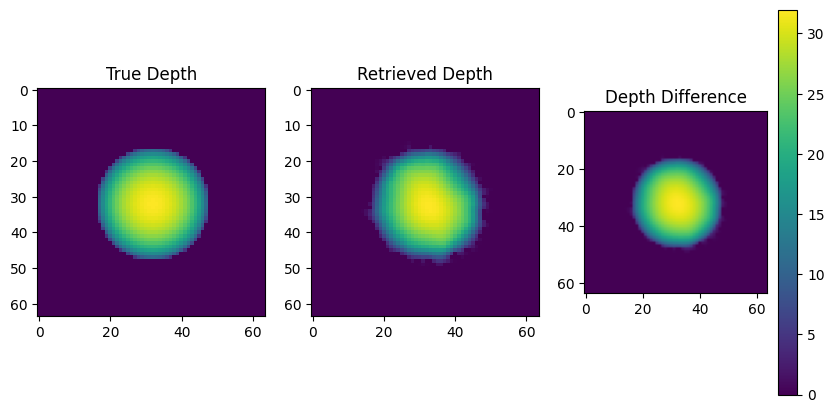

In [ ]:
P_d100_1, Q_d100_1, Z_d100_1 = SFS(1, 16, 0, 0, 0.1, 100)

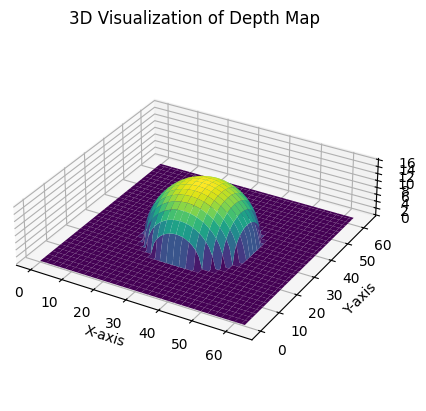

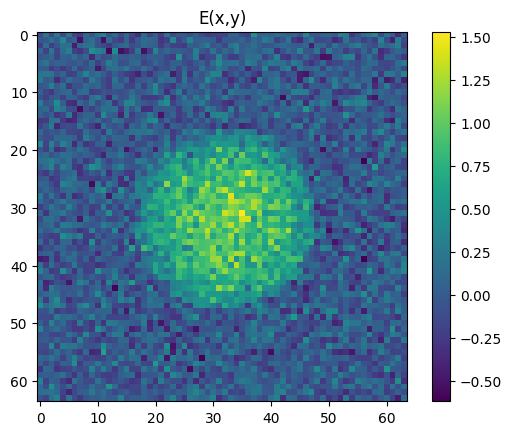

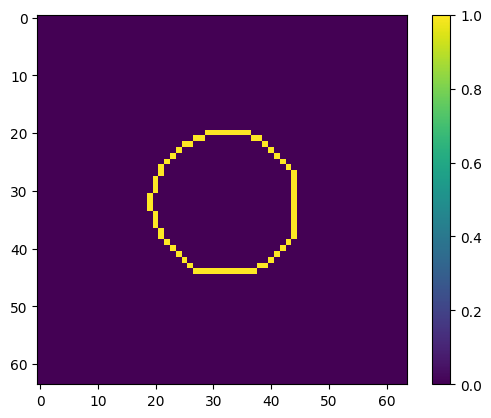

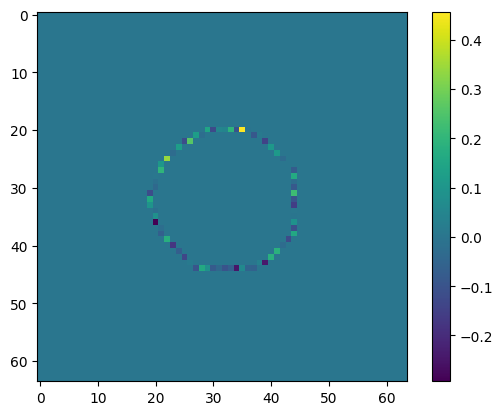

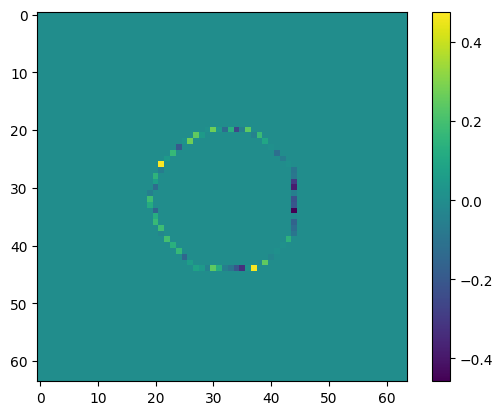

100%|██████████| 1000/1000 [00:30<00:00, 32.40it/s]


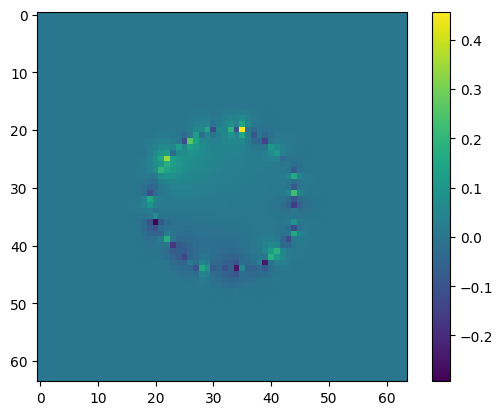

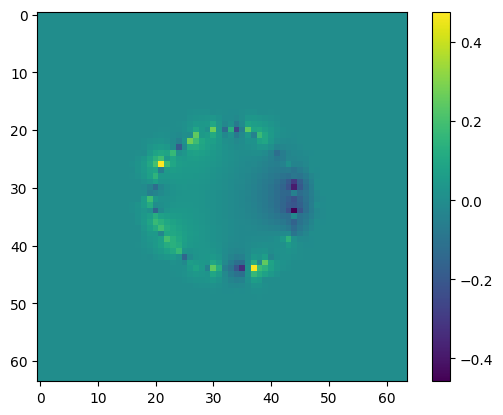

100%|██████████| 1000/1000 [00:15<00:00, 64.95it/s]


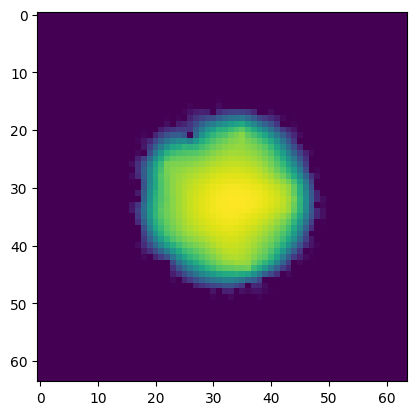

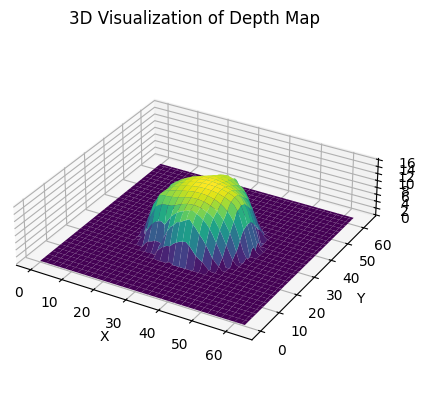

Mean Absolute Error (MAE): 4.135424292219972
Root Mean Squared Error (RMSE): 10.003292422810686
Maximum Absolute Error: 31.952494732906082
Relative Root Mean Squared Error (rel_RMSE): 4.783092107104964


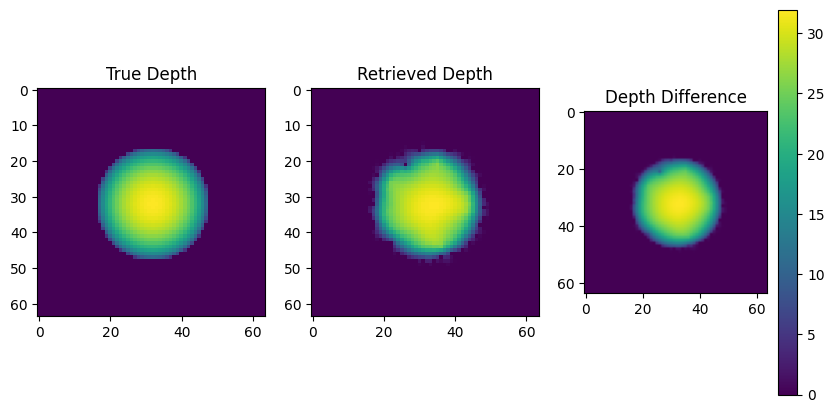

In [ ]:
P_d100_2, Q_d100_2, Z_d100_2  = SFS(1, 16, 0, 0, 0.2, 100)

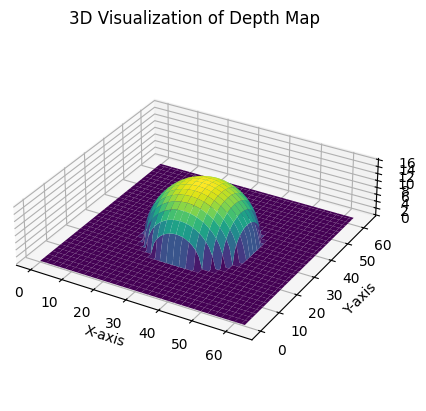

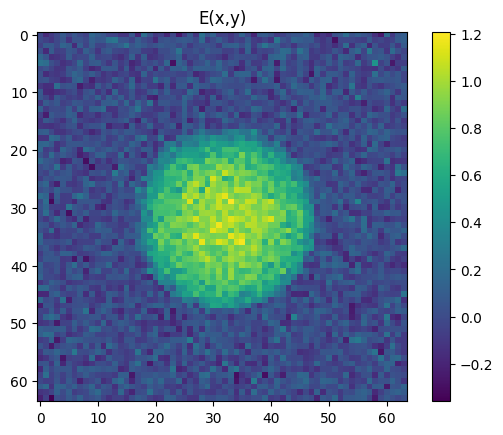

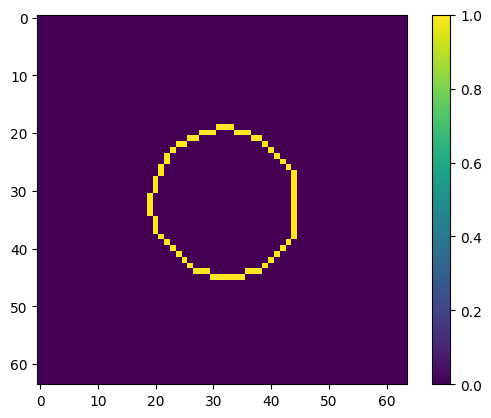

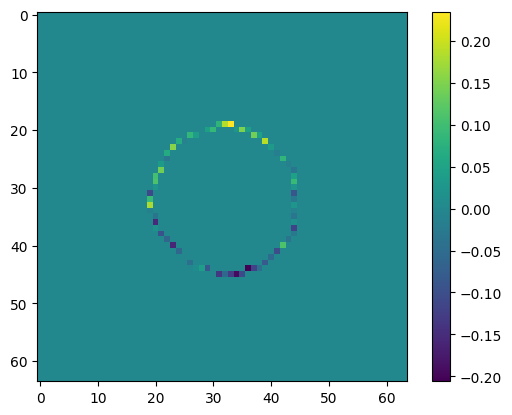

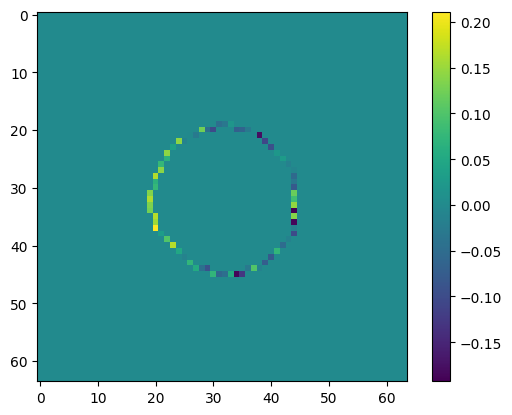

100%|██████████| 1000/1000 [00:32<00:00, 30.87it/s]


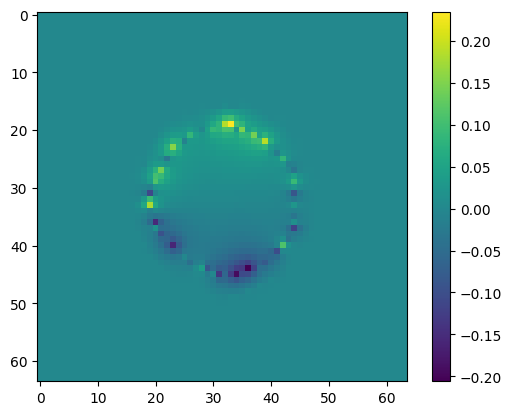

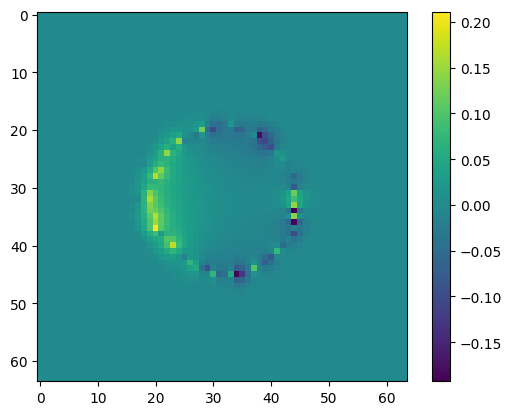

100%|██████████| 1000/1000 [00:15<00:00, 63.30it/s]


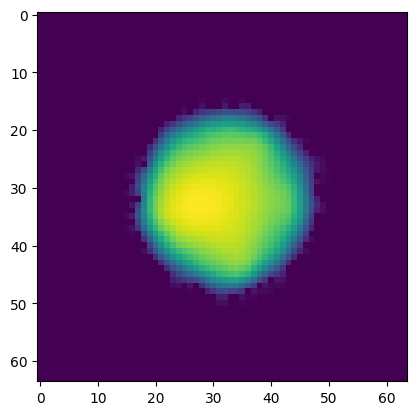

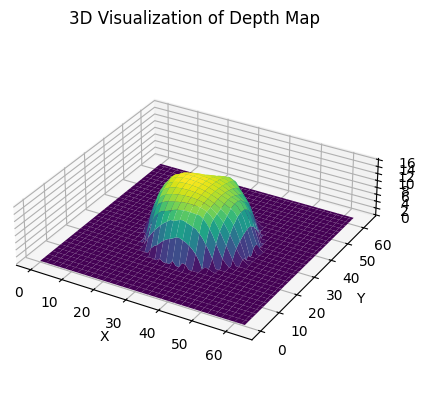

Mean Absolute Error (MAE): 4.179530557717634
Root Mean Squared Error (RMSE): 10.044199747576082
Maximum Absolute Error: 31.72640694254971
Relative Root Mean Squared Error (rel_RMSE): 4.802652017376303


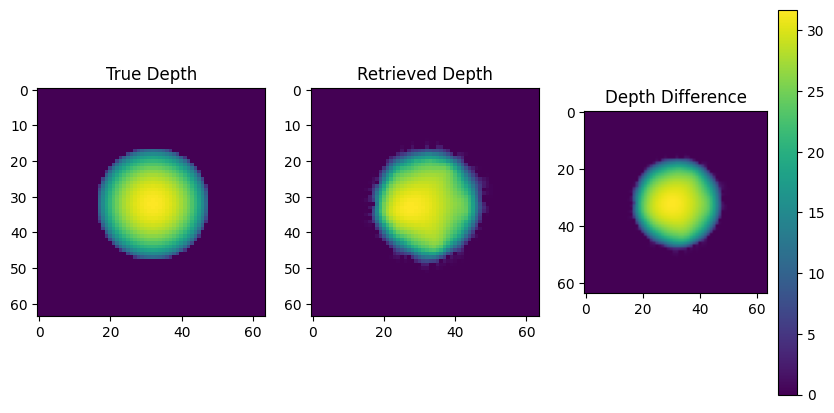

In [ ]:
P_d10_1, Q_d10_1, Z_d10_1  = SFS(1, 16, 0, 0, 0.1, 10)

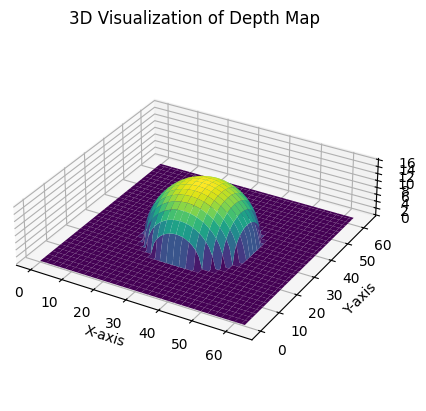

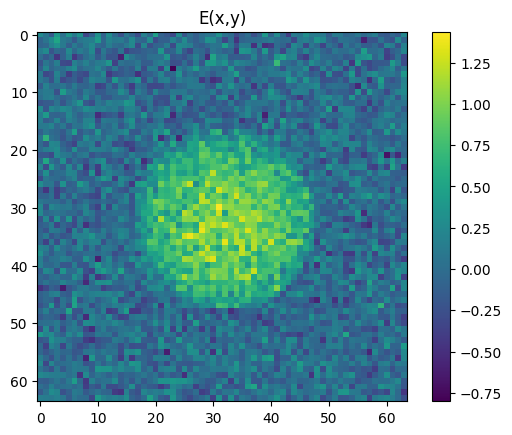

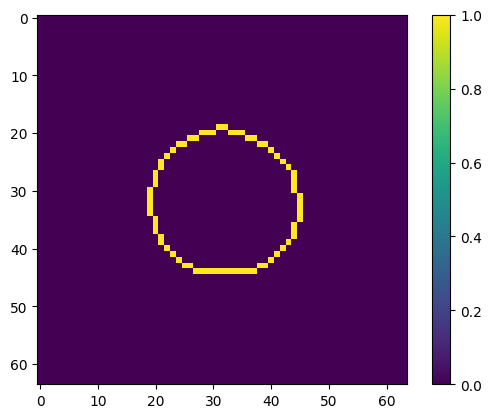

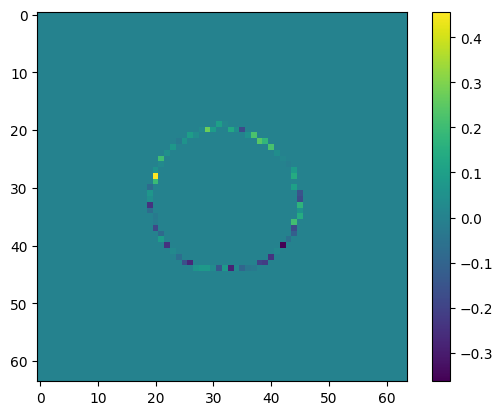

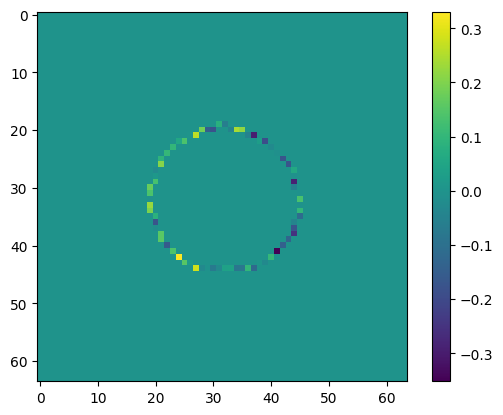

100%|██████████| 1000/1000 [00:31<00:00, 32.02it/s]


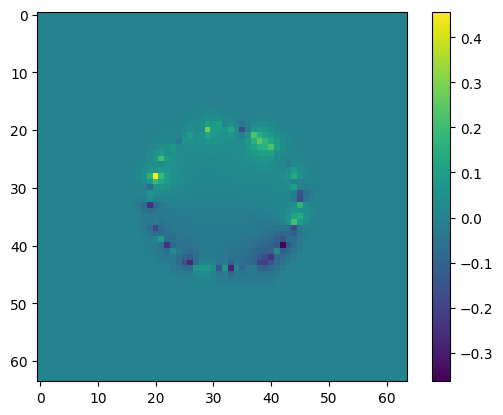

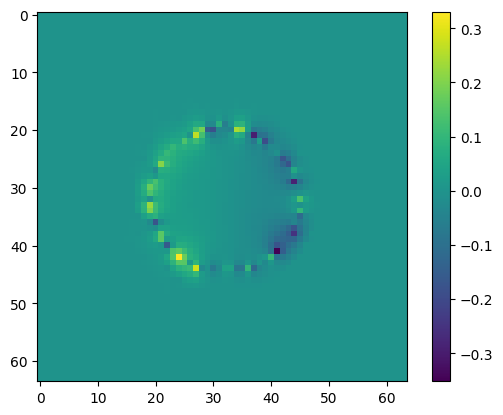

100%|██████████| 1000/1000 [00:15<00:00, 64.70it/s]


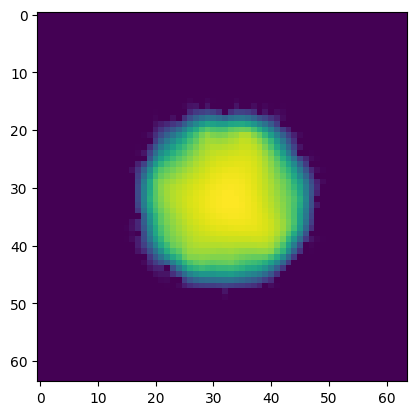

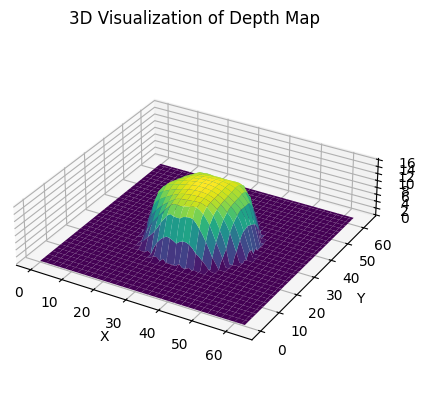

Mean Absolute Error (MAE): 4.245949518670777
Root Mean Squared Error (RMSE): 10.207228021011437
Maximum Absolute Error: 31.977239341161592
Relative Root Mean Squared Error (rel_RMSE): 4.880604276986895


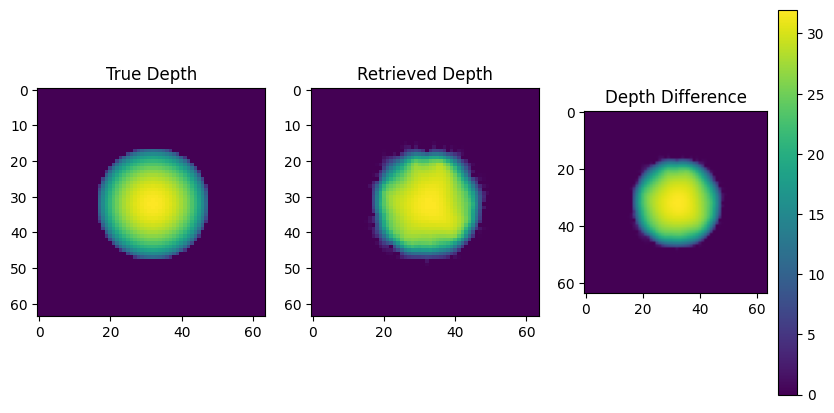

In [ ]:
P_d10_2, Q_d10_2, Z_d10_2  = SFS(1, 16, 0, 0, 0.2, 10)

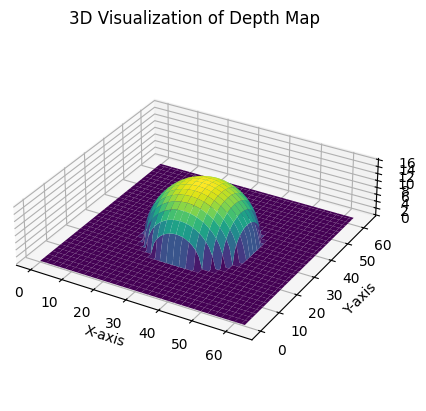

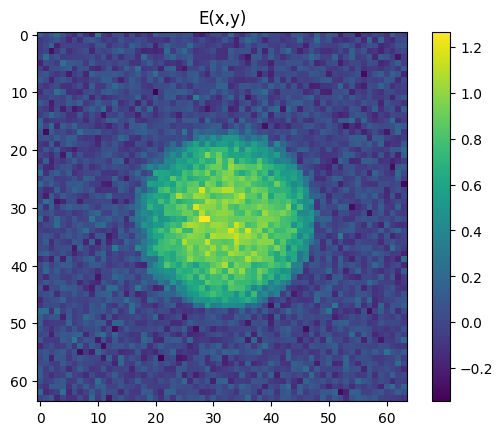

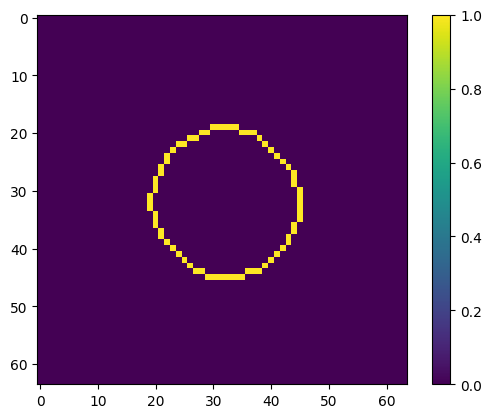

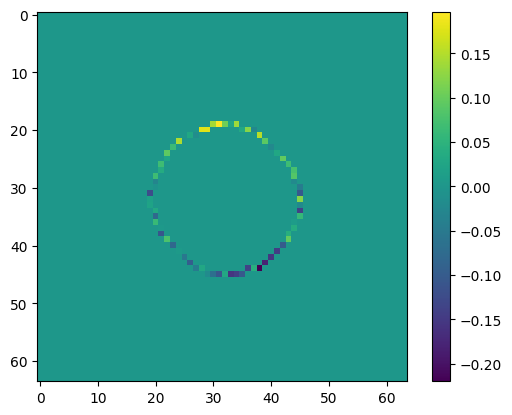

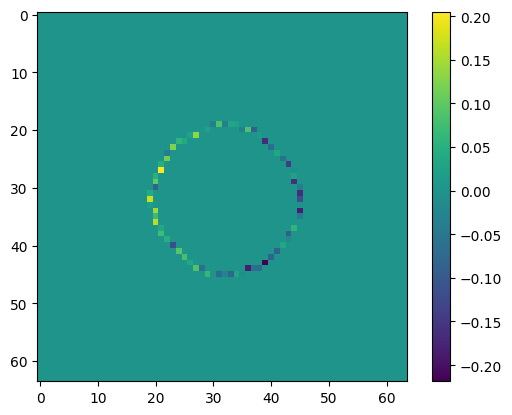

100%|██████████| 1000/1000 [00:31<00:00, 31.51it/s]


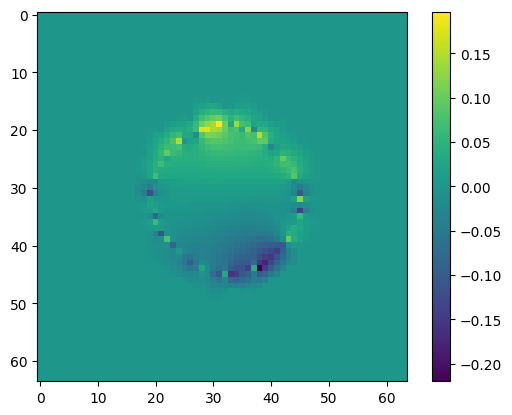

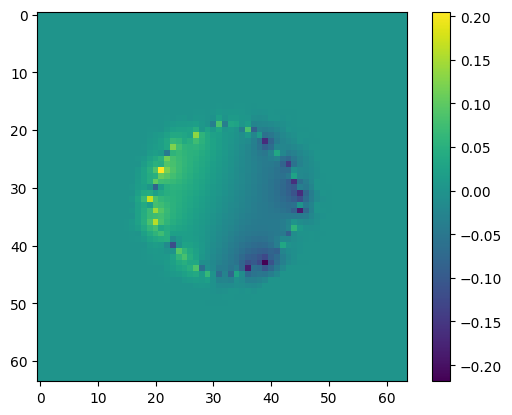

100%|██████████| 1000/1000 [00:15<00:00, 63.70it/s]


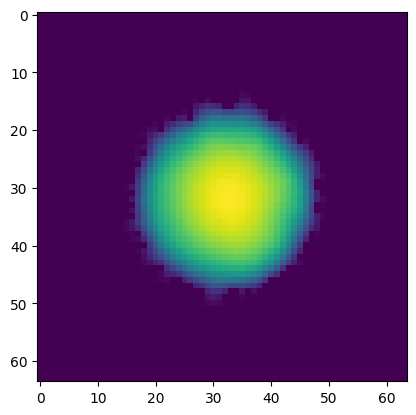

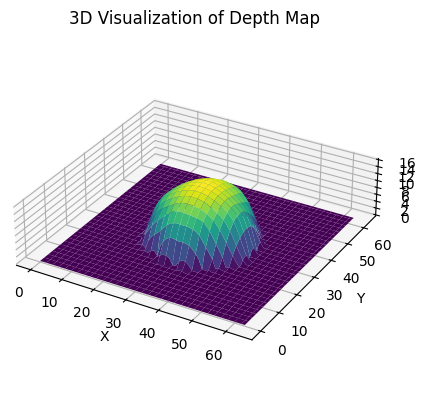

Mean Absolute Error (MAE): 4.048549623079715
Root Mean Squared Error (RMSE): 9.751022000568511
Maximum Absolute Error: 31.969263999647243
Relative Root Mean Squared Error (rel_RMSE): 4.662468554930174


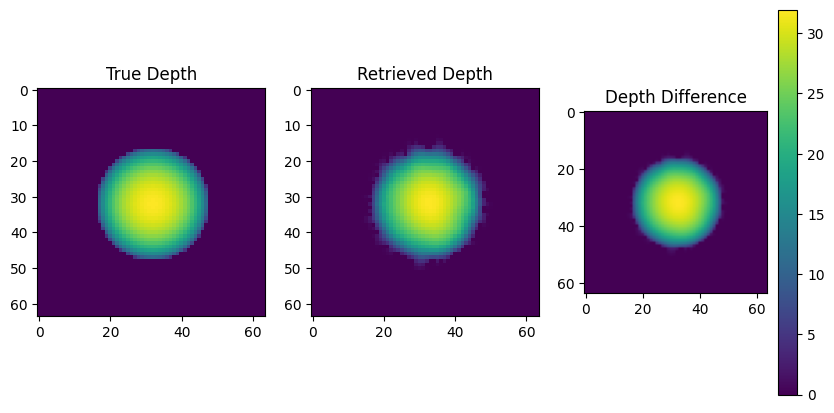

In [ ]:
P_d1000_1, Q_d1000_1, Z_d1000_1  = SFS(1, 16, 0, 0, 0.1, 1000)

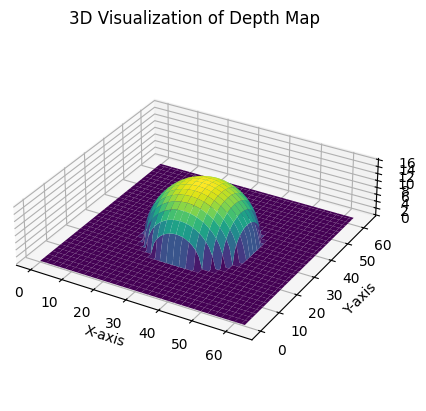

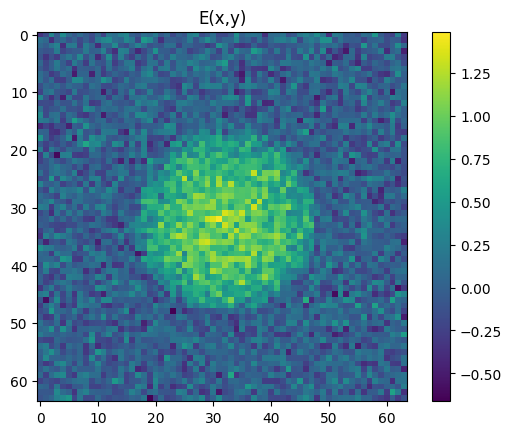

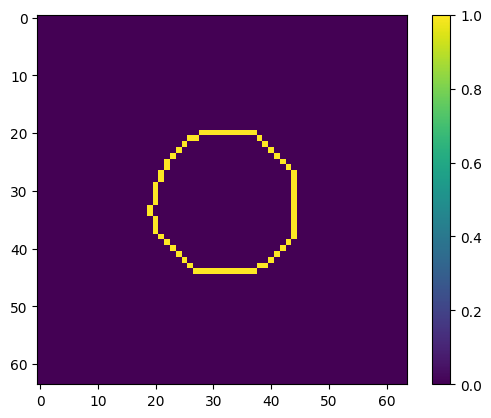

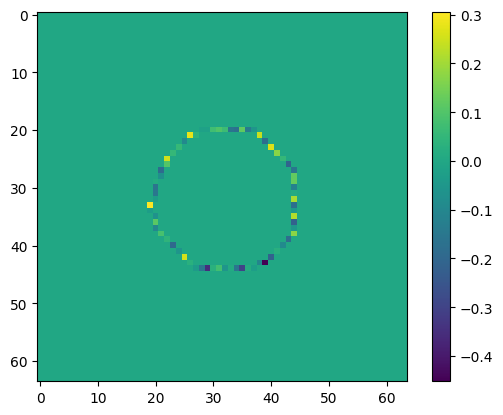

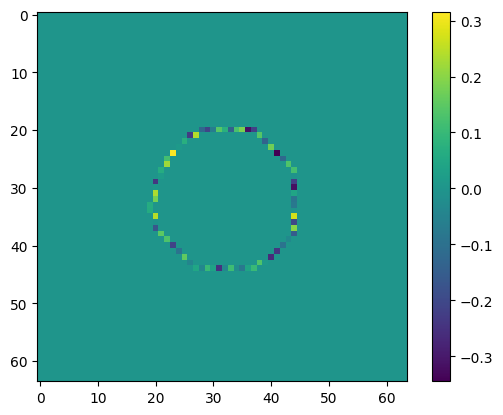

100%|██████████| 1000/1000 [00:31<00:00, 31.51it/s]


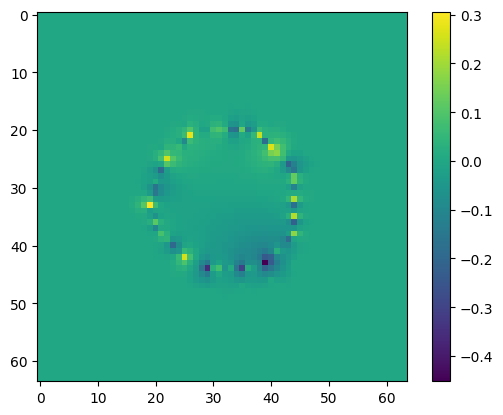

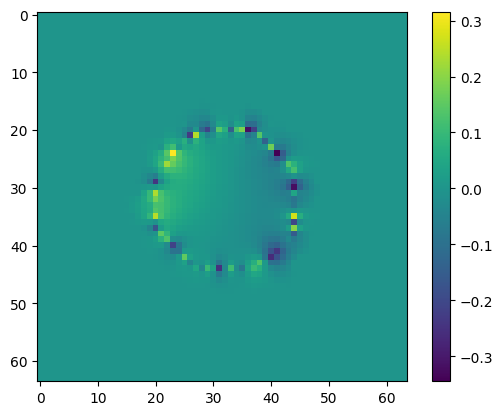

100%|██████████| 1000/1000 [00:15<00:00, 65.05it/s]


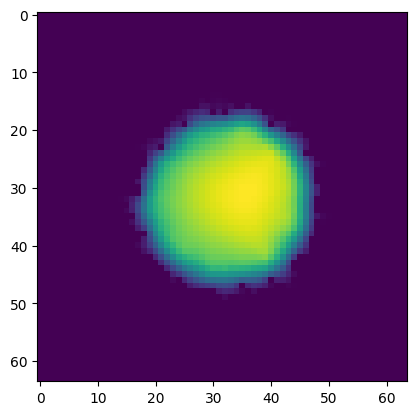

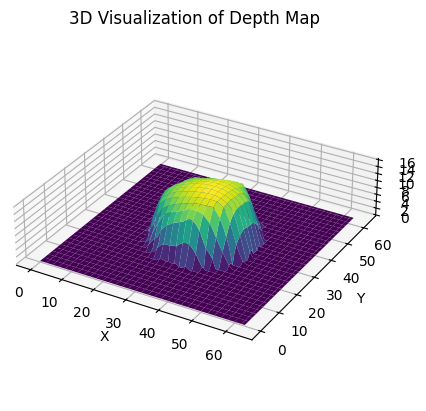

Mean Absolute Error (MAE): 4.148041027017824
Root Mean Squared Error (RMSE): 10.026070322175851
Maximum Absolute Error: 31.77415884934219
Relative Root Mean Squared Error (rel_RMSE): 4.793983400297745


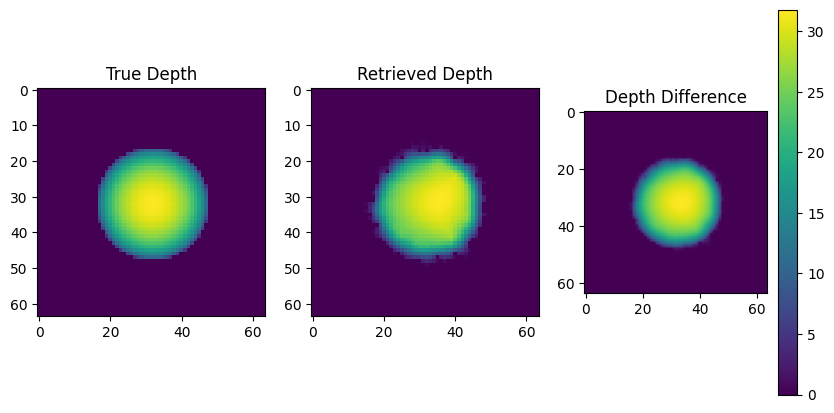

In [ ]:
P_d1000_2, Q_d1000_2, Z_d1000_2  = SFS(1, 16, 0, 0, 0.2, 1000)